####**SKENARIO 4 UNET**

**SPLIT DATA 70:30**

**AUGMENTASI OFFLINE**

**BATCH SIZE KLASIFIKASI 16 & 32**

**MENGGUNAKAN UNET**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Path folder ALPUKAT di Google Drive
project_path = '/content/drive/MyDrive/alpukat/dataset'
os.chdir(project_path)

# Verifikasi isi folder
!ls

best_class1_rsunet01.h5  best_unet01_model.h5	 maskedunet01_train
best_class1_rsunet02.h5  best_unet02_model.h5	 maskedunet02_test
best_class1_rsunet1.h5	 best_unet1_model.h5	 maskedunet02_train
best_class1_rsunet2.h5	 best_unet2_model.h5	 maskedunet1_train
best_class1_rsunet7.h5	 best_unet3_model.h5	 maskedunet2_test
best_class1_rsunet8.h5	 best_unet4_model.h5	 maskedunet2_train
best_class1_unet01.h5	 images			 maskedunet3_test
best_class1_unet1.h5	 images_aug		 maskedunet3_train
best_class1_unet2.h5	 images_augment		 maskedunet4_test
best_class1_unet3.h5	 labels_converted.csv	 maskedunet4_train
best_class2_rsunet01.h5  labels.csv		 masks
best_class2_rsunet02.h5  labels.gsheet		 masks_aug
best_class2_rsunet1.h5	 logs			 masks_augment
best_class2_rsunet2.h5	 maskedrsunet01_test	 model.ipynb
best_class2_rsunet7.h5	 maskedrsunet01_train	 training_history1.json
best_class2_rsunet8.h5	 maskedrsunet02_test	 training_history2.json
best_class2_unet01.h5	 maskedrsunet02_train	 training_history

In [ ]:
pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import os
import glob
import random
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import MeanIoU, SparseCategoricalAccuracy
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import json
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import pandas as pd
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Conv2DTranspose, Concatenate, Input, GlobalAveragePooling2D, Reshape, Dense, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

In [ ]:
image_paths = sorted(glob.glob('/content/drive/MyDrive/alpukat/dataset/images_aug/*.*'))  # Untuk semua tipe gambar
mask_paths = sorted(glob.glob('/content/drive/MyDrive/alpukat/dataset/masks_aug/*.*'))

print(len(image_paths))
print(len(mask_paths))

5850
5850


In [ ]:
label_map = {
    0: "miki",
    1: "aligator",
    2: "marcus"
}

# Jika kamu ingin tetap mendapatkan label numerik, kamu perlu membalik mapping-nya:
reverse_label_map = {v: k for k, v in label_map.items()}
labels = [reverse_label_map[os.path.basename(path).split('_')[0]] for path in image_paths]

In [ ]:
# Gunakan stratified split untuk menjaga proporsi kelas tetap
train_image_paths, test_image_paths, train_mask_paths, test_mask_paths, train_labels, test_labels = train_test_split(
    image_paths, mask_paths, labels,
    test_size=0.3,
    stratify=labels,   # menjaga distribusi kelas
    random_state=42
)


In [ ]:
from collections import Counter

# Hitung jumlah masing-masing label di data training
label_counts = Counter(train_labels)

# Tampilkan hasilnya
for label, count in label_counts.items():
    print(f"Label {label}: {count} data")


Label 1: 1365 data
Label 0: 1365 data
Label 2: 1365 data


In [ ]:
# # Sample 6 random image paths
# sample_paths = random.sample(list(zip(image_paths, mask_paths)), 6)

# plt.figure(figsize=(20, 10))

# for i, (image_path, mask_path) in enumerate(sample_paths):
#     # Ambil label dari nama file (misalnya, class diambil dari nama file gambar)
#     class_name = os.path.basename(image_path).split('_')[0]
#     label_name = class_name if class_name in label_map else 'unknown'

#     # Load dan proses gambar
#     img = tf.image.decode_jpeg(tf.io.read_file(image_path), channels=3)
#     img = tf.image.resize(img, (128, 128)) / 255.0

#     # Load dan proses mask
#     mask = tf.image.decode_jpeg(tf.io.read_file(mask_path), channels=1)  # Mask grayscale
#     mask = tf.image.resize(mask, (128, 128)) / 255.0  # Resize mask agar sesuai dengan gambar

#     # Plot gambar asli
#     plt.subplot(3, 6, i + 1)  # Baris 1, Gambar asli
#     plt.imshow(img)
#     plt.title(f"Label: {label_name}")
#     plt.axis('off')

#     # Plot true mask
#     plt.subplot(3, 6, i + 7)  # Baris 2, True mask
#     plt.imshow(mask, cmap='plasma')  # Gunakan colormap untuk visualisasi mask
#     plt.title("True Mask")
#     plt.axis('off')

# plt.tight_layout()
# plt.show()

##**DATA PREPROCESSING DAN AUGMENTASI**##

In [ ]:
def load_and_preprocess_image(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.cast(mask, tf.float32) / 255.0

    # Thresholding untuk membentuk mask biner
    mask = tf.where(mask > 0.5, 1.0, 0.0)

    return image, mask

In [ ]:
# Dataset untuk train
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 16

train_unet_ds = tf.data.Dataset.from_tensor_slices((train_image_paths, train_mask_paths))
train_unet_ds = train_unet_ds.map(lambda image_path, mask_path: load_and_preprocess_image(image_path, mask_path),
                                  num_parallel_calls=AUTOTUNE)
train_unet_ds = train_unet_ds.shuffle(100).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Dataset untuk test
test_unet_ds = tf.data.Dataset.from_tensor_slices((test_image_paths, test_mask_paths))
test_unet_ds = test_unet_ds.map(lambda image_path, mask_path: load_and_preprocess_image(image_path, mask_path),
                                num_parallel_calls=AUTOTUNE)
test_unet_ds = test_unet_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

##**UNET MODEL**##

In [ ]:
def double_conv_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding='same')(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)
    return x

In [ ]:
# --- U-Net Segmentasi ---
def build_unet():
    inputs = layers.Input(shape=(128, 128, 3))

    # Encoder
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)

    # Bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # Decoder
    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)

    # Output segmentasi
    segmentation_output = layers.Conv2D(1, (1, 1), activation='sigmoid', name='segmentation')(u9)

    model = models.Model(inputs=inputs, outputs=segmentation_output, name='U-Net-Segmenter')
    return model

In [ ]:
# Membuat model U-Net
unet_model = build_unet()

# Menampilkan summary dari model U-Net
unet_model.summary()

Model: "U-Net-Segmenter"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_18[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_19[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 64, 64,    │     73,856 │ dropout_8[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_20[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_21[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 32, 32,    │    295,168 │ dropout_9[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_22[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 16, 16,    │          0 │ conv2d_23[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 16, 16,    │          0 │ max_pooling2d_6[… │
│ (Dropout)           │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ dropout_10[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_24[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 8, 8, 512) │          0 │ conv2d_25[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 8, 8, 512) │          0 │ max_pooling2d_7[

 Total params: 34,513,345 (131.66 MB)

 Trainable params: 34,513,345 (131.66 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Menggunakan threshold 0.5 untuk prediksi
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

In [ ]:
# Kompilasi model
unet_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Ganti dengan IoU loss jika sudah didefinisikan
    metrics=[iou_metric]
)

# Definisikan callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_unet02_model.h5', save_best_only=True, monitor='val_loss', mode='min')
]

In [ ]:
# Melatih model
history = unet_model.fit(
    train_unet_ds,
    epochs=100,
    validation_data=test_unet_ds,
    steps_per_epoch=len(train_unet_ds),
    validation_steps=len(test_unet_ds),
    callbacks=callbacks
)

Epoch 1/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - iou_metric: 0.4769 - loss: 0.2993

256/256 ━━━━━━━━━━━━━━━━━━━━ 111s 362ms/step - iou_metric: 0.4777 - loss: 0.2989 - val_iou_metric: 0.8679 - val_loss: 0.0712
Epoch 2/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - iou_metric: 0.8670 - loss: 0.0699

256/256 ━━━━━━━━━━━━━━━━━━━━ 120s 319ms/step - iou_metric: 0.8670 - loss: 0.0698 - val_iou_metric: 0.9212 - val_loss: 0.0390
Epoch 3/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - iou_metric: 0.9164 - loss: 0.0434

256/256 ━━━━━━━━━━━━━━━━━━━━ 143s 324ms/step - iou_metric: 0.9164 - loss: 0.0433 - val_iou_metric: 0.9477 - val_loss: 0.0265
Epoch 4/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - iou_metric: 0.9483 - loss: 0.0253

256/256 ━━━━━━━━━━━━━━━━━━━━ 94s 367ms/step - iou_metric: 0.9483 - loss: 0.0253 - val_iou_metric: 0.9603 - val_loss: 0.0194
Epoch 5/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - iou_metric: 0.9556 - loss: 0.0217

256/256 ━━━━━━━━━━━━━━━━━━━━ 126s 305ms/step - iou_metric: 0.9556 - loss: 0.0217 - val_iou_metric: 0.9619 - val_loss: 0.0188
Epoch 6/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - iou_metric: 0.9575 - loss: 0.0211

256/256 ━━━━━━━━━━━━━━━━━━━━ 97s 365ms/step - iou_metric: 0.9575 - loss: 0.0211 - val_iou_metric: 0.9658 - val_loss: 0.0165
Epoch 7/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 124s 296ms/step - iou_metric: 0.9567 - loss: 0.0215 - val_iou_metric: 0.9644 - val_loss: 0.0171
Epoch 8/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - iou_metric: 0.9544 - loss: 0.0235

256/256 ━━━━━━━━━━━━━━━━━━━━ 87s 338ms/step - iou_metric: 0.9544 - loss: 0.0235 - val_iou_metric: 0.9697 - val_loss: 0.0142
Epoch 9/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 131s 296ms/step - iou_metric: 0.9686 - loss: 0.0149 - val_iou_metric: 0.9689 - val_loss: 0.0147
Epoch 10/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - iou_metric: 0.9688 - loss: 0.0149

256/256 ━━━━━━━━━━━━━━━━━━━━ 91s 330ms/step - iou_metric: 0.9688 - loss: 0.0149 - val_iou_metric: 0.9713 - val_loss: 0.0135
Epoch 11/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - iou_metric: 0.9701 - loss: 0.0144

256/256 ━━━━━━━━━━━━━━━━━━━━ 98s 379ms/step - iou_metric: 0.9701 - loss: 0.0144 - val_iou_metric: 0.9720 - val_loss: 0.0134
Epoch 12/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - iou_metric: 0.9716 - loss: 0.0136

256/256 ━━━━━━━━━━━━━━━━━━━━ 127s 321ms/step - iou_metric: 0.9716 - loss: 0.0136 - val_iou_metric: 0.9739 - val_loss: 0.0123
Epoch 13/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - iou_metric: 0.9735 - loss: 0.0124

256/256 ━━━━━━━━━━━━━━━━━━━━ 141s 317ms/step - iou_metric: 0.9735 - loss: 0.0124 - val_iou_metric: 0.9756 - val_loss: 0.0115
Epoch 14/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 84s 326ms/step - iou_metric: 0.9691 - loss: 0.0154 - val_iou_metric: 0.9685 - val_loss: 0.0156
Epoch 15/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 133s 293ms/step - iou_metric: 0.9698 - loss: 0.0146 - val_iou_metric: 0.9743 - val_loss: 0.0121
Epoch 16/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 76s 293ms/step - iou_metric: 0.9749 - loss: 0.0118 - val_iou_metric: 0.9753 - val_loss: 0.0117
Epoch 17/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 75s 290ms/step - iou_metric: 0.9736 - loss: 0.0127 - val_iou_metric: 0.9757 - val_loss: 0.0115
Epoch 18/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - iou_metric: 0.9765 - loss: 0.0110

256/256 ━━━━━━━━━━━━━━━━━━━━ 88s 343ms/step - iou_metric: 0.9765 - loss: 0.0110 - val_iou_metric: 0.9776 - val_loss: 0.0106
Epoch 19/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - iou_metric: 0.9779 - loss: 0.0103

256/256 ━━━━━━━━━━━━━━━━━━━━ 140s 334ms/step - iou_metric: 0.9779 - loss: 0.0103 - val_iou_metric: 0.9777 - val_loss: 0.0105
Epoch 20/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 84s 326ms/step - iou_metric: 0.9780 - loss: 0.0104 - val_iou_metric: 0.9726 - val_loss: 0.0131
Epoch 21/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 133s 293ms/step - iou_metric: 0.9671 - loss: 0.0172 - val_iou_metric: 0.9695 - val_loss: 0.0154
Epoch 22/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 75s 293ms/step - iou_metric: 0.9618 - loss: 0.0204 - val_iou_metric: 0.9758 - val_loss: 0.0114
Epoch 23/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 82s 293ms/step - iou_metric: 0.9764 - loss: 0.0111 - val_iou_metric: 0.9753 - val_loss: 0.0117
Epoch 24/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - iou_metric: 0.9768 - loss: 0.0109

256/256 ━━━━━━━━━━━━━━━━━━━━ 89s 321ms/step - iou_metric: 0.9768 - loss: 0.0109 - val_iou_metric: 0.9779 - val_loss: 0.0103
Epoch 25/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - iou_metric: 0.9790 - loss: 0.0097

256/256 ━━━━━━━━━━━━━━━━━━━━ 142s 323ms/step - iou_metric: 0.9790 - loss: 0.0097 - val_iou_metric: 0.9794 - val_loss: 0.0096
Epoch 26/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 134s 291ms/step - iou_metric: 0.9791 - loss: 0.0097 - val_iou_metric: 0.9755 - val_loss: 0.0119
Epoch 27/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 75s 292ms/step - iou_metric: 0.9722 - loss: 0.0141 - val_iou_metric: 0.9739 - val_loss: 0.0125
Epoch 28/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 82s 290ms/step - iou_metric: 0.9712 - loss: 0.0145 - val_iou_metric: 0.9766 - val_loss: 0.0111
Epoch 29/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - iou_metric: 0.9775 - loss: 0.0106

256/256 ━━━━━━━━━━━━━━━━━━━━ 95s 342ms/step - iou_metric: 0.9775 - loss: 0.0106 - val_iou_metric: 0.9793 - val_loss: 0.0096
Epoch 30/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 83s 322ms/step - iou_metric: 0.9793 - loss: 0.0096 - val_iou_metric: 0.9778 - val_loss: 0.0106
Epoch 31/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - iou_metric: 0.9792 - loss: 0.0097

256/256 ━━━━━━━━━━━━━━━━━━━━ 83s 321ms/step - iou_metric: 0.9792 - loss: 0.0097 - val_iou_metric: 0.9797 - val_loss: 0.0094
Epoch 32/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - iou_metric: 0.9804 - loss: 0.0090

256/256 ━━━━━━━━━━━━━━━━━━━━ 146s 336ms/step - iou_metric: 0.9804 - loss: 0.0090 - val_iou_metric: 0.9806 - val_loss: 0.0091
Epoch 33/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - iou_metric: 0.9813 - loss: 0.0086

256/256 ━━━━━━━━━━━━━━━━━━━━ 94s 365ms/step - iou_metric: 0.9813 - loss: 0.0086 - val_iou_metric: 0.9808 - val_loss: 0.0090
Epoch 34/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 84s 325ms/step - iou_metric: 0.9815 - loss: 0.0084 - val_iou_metric: 0.9810 - val_loss: 0.0090
Epoch 35/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 133s 292ms/step - iou_metric: 0.9816 - loss: 0.0084 - val_iou_metric: 0.9806 - val_loss: 0.0090
Epoch 36/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 81s 290ms/step - iou_metric: 0.9792 - loss: 0.0099 - val_iou_metric: 0.9718 - val_loss: 0.0142
Epoch 37/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 82s 292ms/step - iou_metric: 0.9680 - loss: 0.0167 - val_iou_metric: 0.9760 - val_loss: 0.0116
Epoch 38/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 82s 292ms/step - iou_metric: 0.9779 - loss: 0.0105 - val_iou_metric: 0.9800 - val_loss: 0.0093
Epoch 39/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 74s 289ms/step - iou_metric: 0.9805 - loss: 0.0089 - val_iou_metric: 0.9806 - val_loss: 0.0091
Epoch 40/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 75s 289ms/s

In [ ]:
# Simpan history ke file JSON
history_dict = history.history
with open('training_history_unet02.json', 'w') as json_file:
    json.dump(history_dict, json_file)

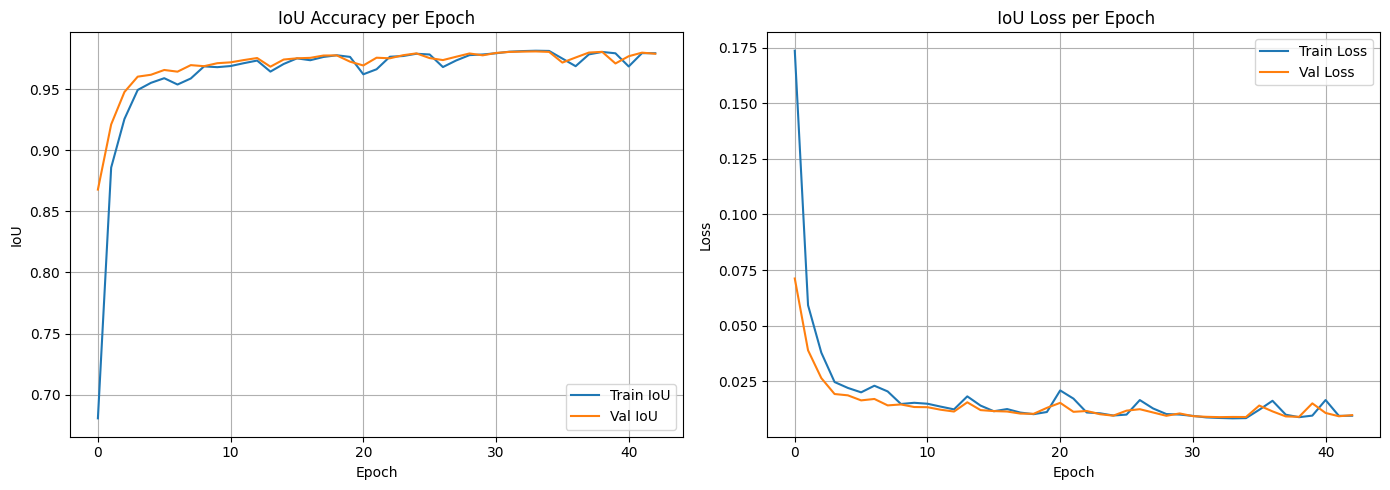

In [ ]:
# Ekstrak data dari history
history_dict = history.history

# Buat plot
plt.figure(figsize=(14, 5))

# Plot IoU (iou_metric)
plt.subplot(1, 2, 1)
plt.plot(history_dict['iou_metric'], label='Train IoU')
plt.plot(history_dict['val_iou_metric'], label='Val IoU')
plt.title('IoU Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.title(' IoU Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


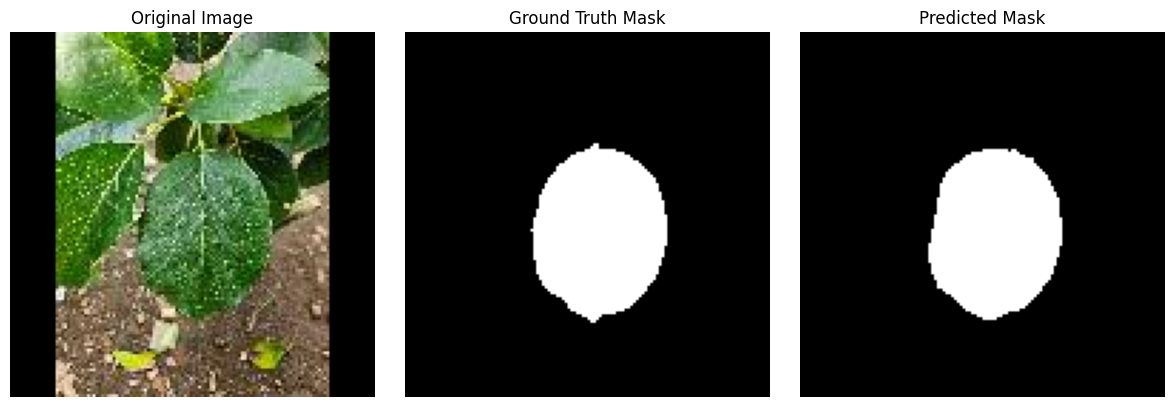

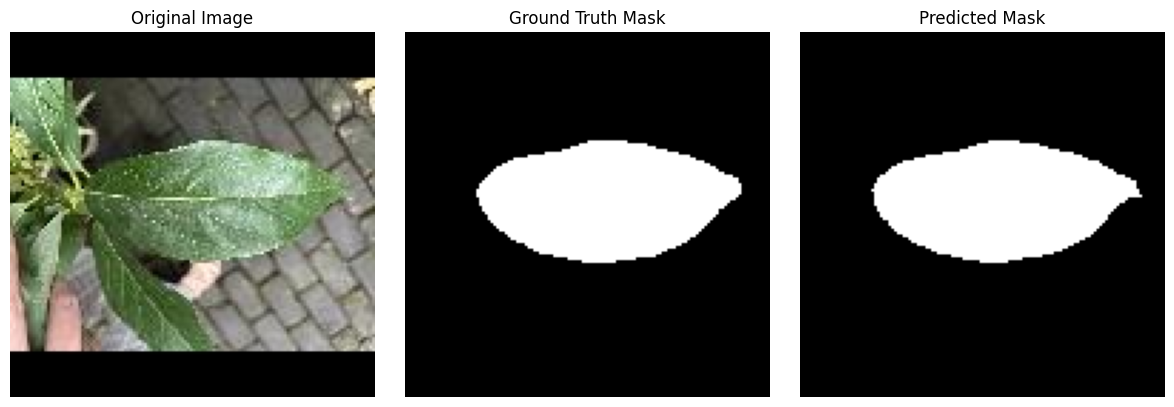

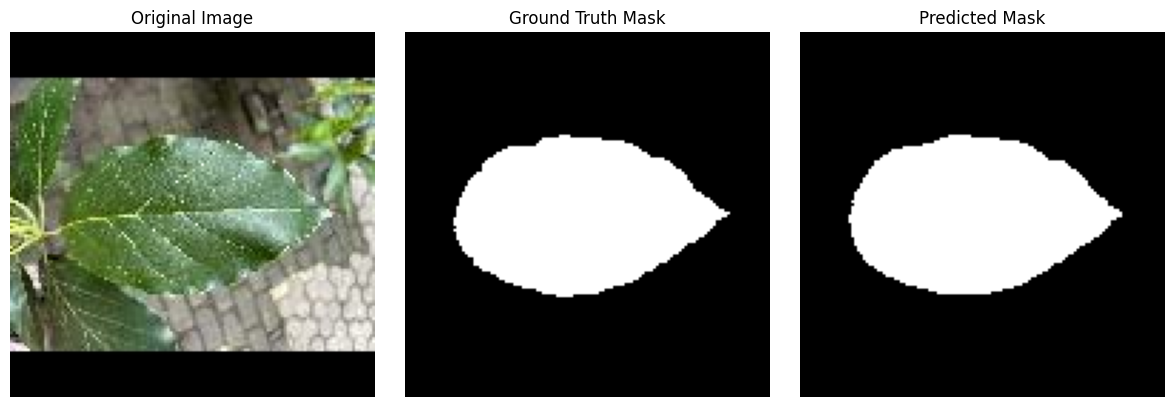

In [ ]:
def display_sample_prediction(unet_model, dataset, num_samples=3):
    for images, masks in dataset.take(1):
        preds = unet_model.predict(images)
        preds = (preds > 0.5).astype(np.uint8)  # Threshold prediksi

        for i in range(num_samples):
            image = images[i].numpy()
            gt_mask = masks[i].numpy().squeeze()
            pred_mask = preds[i].squeeze()

            plt.figure(figsize=(12, 4))

            # Gambar asli
            plt.subplot(1, 3, 1)
            plt.imshow(image)
            plt.title("Original Image")
            plt.axis('off')

            # Ground truth mask
            plt.subplot(1, 3, 2)
            plt.imshow(gt_mask, cmap='gray')
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Predicted mask
            plt.subplot(1, 3, 3)
            plt.imshow(pred_mask, cmap='gray')
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()

display_sample_prediction(unet_model, test_unet_ds, num_samples=3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


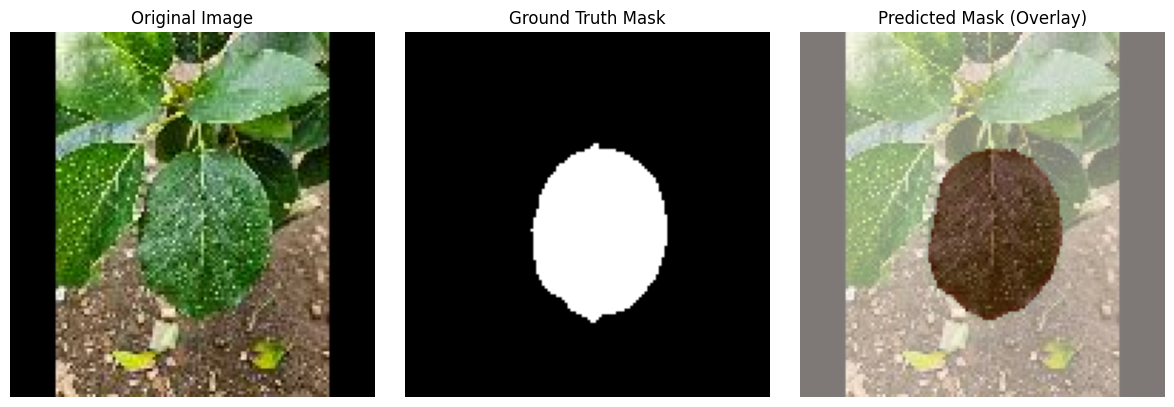

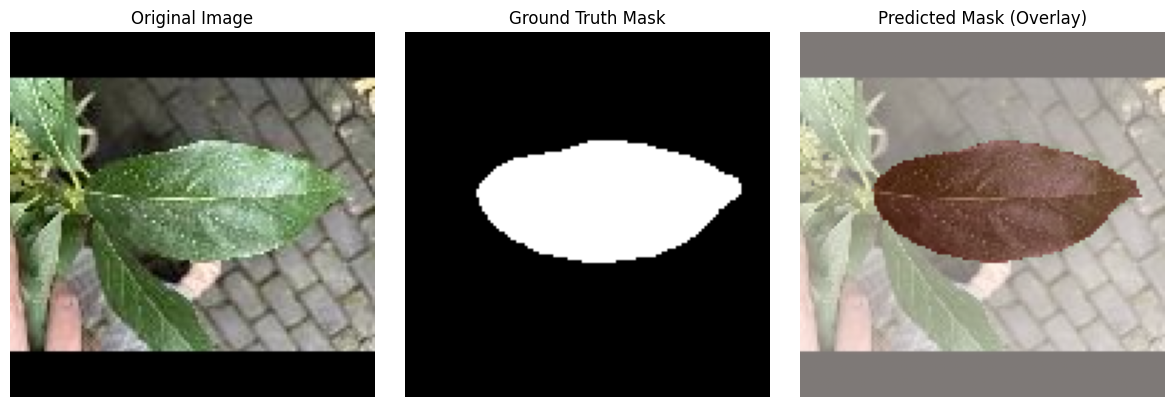

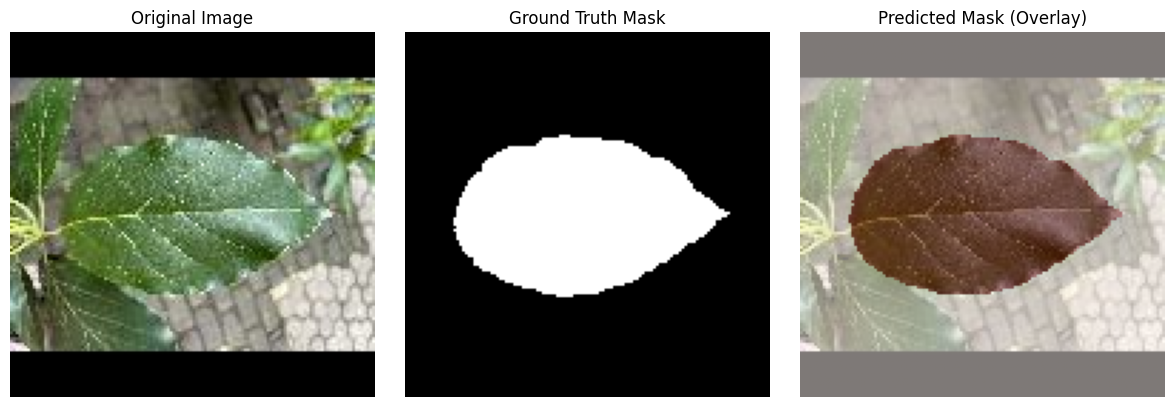

In [ ]:
def display_sample_prediction(unet_model, dataset, num_samples=3):
    for images, masks in dataset.take(1):
        preds = unet_model.predict(images)
        preds = (preds > 0.5).astype(np.uint8)  # Threshold prediksi

        for i in range(num_samples):
            image = images[i].numpy()
            gt_mask = masks[i].numpy().squeeze()
            pred_mask = preds[i].squeeze()

            plt.figure(figsize=(12, 4))

            # Gambar asli
            plt.subplot(1, 3, 1)
            plt.imshow(image)
            plt.title("Original Image")
            plt.axis('off')

            # Ground truth mask
            plt.subplot(1, 3, 2)
            plt.imshow(gt_mask, cmap='gray')
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Predicted mask overlay dengan gambar asli
            plt.subplot(1, 3, 3)
            plt.imshow(image)
            plt.imshow(pred_mask, cmap='Reds', alpha=0.5)  # Overlay mask
            plt.title("Predicted Mask (Overlay)")
            plt.axis('off')

            plt.tight_layout()
            plt.show()

display_sample_prediction(unet_model, test_unet_ds, num_samples=3)

##**CLASSIFICATION MODEL**##

In [ ]:
from tensorflow.keras.models import load_model

# Load model U-Net dari checkpoint
unet_model = load_model('/content/drive/MyDrive/alpukat/dataset/best_unet02_model.h5')

In [ ]:
import tensorflow as tf

# Mapping string ke angka (lowercase)
reverse_label_map = {v.lower(): k for k, v in label_map.items()}

# TensorFlow lookup table
keys_tensor = tf.constant(list(reverse_label_map.keys()))
vals_tensor = tf.constant(list(reverse_label_map.values()), dtype=tf.int32)

table_init = tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor)
label_table = tf.lookup.StaticHashTable(table_init, default_value=-1)

# Fungsi untuk mengambil label dari nama file
def extract_label_from_filename_tf(filename):
    filename = tf.strings.lower(filename)
    label_str = tf.strings.split(filename, '_')[0]
    return label_table.lookup(label_str)

In [ ]:
def apply_rsunet_segmentation_to_image(image, outputs, threshold=0.5):
    if isinstance(image, tf.Tensor):
        image = tf.cast(image, tf.float32)

    if image.shape[-1] != 3:
        raise ValueError(f"Image must have 3 channels. Got shape: {image.shape}")

    binary_mask = tf.cast(outputs > threshold, tf.float32)
    if len(binary_mask.shape) == 2:
        binary_mask = tf.expand_dims(binary_mask, axis=-1)
    binary_mask_rgb = tf.repeat(binary_mask, repeats=3, axis=-1)

    if binary_mask_rgb.shape != image.shape:
        binary_mask_rgb = tf.image.resize(binary_mask_rgb, image.shape[:2])

    masked_image = image * binary_mask_rgb
    return masked_image

from tqdm import tqdm
import tensorflow as tf
import os

def save_masked_dataset(image_paths, model, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    for path in tqdm(image_paths):
        # Load image (sudah 128x128 dan normalisasi dilakukan saat load_image_and_label)
        image_raw = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image_raw, channels=3)
        image = tf.cast(image, tf.float32) / 255.0  # Normalisasi dilakukan sekali saja di sini jika tidak dilakukan sebelumnya

        # Predict mask
        pred = model(tf.expand_dims(image, 0), training=False)
        pred = tf.squeeze(pred, axis=0)

        # Apply mask
        masked_image = apply_rsunet_segmentation_to_image(image, pred)

        # Simpan hasil
        fname = os.path.basename(path)
        save_path = os.path.join(save_dir, fname)
        masked_uint8 = tf.image.convert_image_dtype(masked_image, tf.uint8)
        encoded = tf.image.encode_jpeg(masked_uint8)
        tf.io.write_file(save_path, encoded)

save_masked_dataset(train_image_paths, unet_model, "maskedunet02_train")
save_masked_dataset(test_image_paths, unet_model, "maskedunet02_test")

In [ ]:
def apply_rsunet_segmentation_to_image(image, outputs, threshold=0.5):
    if isinstance(image, tf.Tensor):
        image = tf.cast(image, tf.float32)

    if image.shape[-1] != 3:
        raise ValueError(f"Image must have 3 channels. Got shape: {image.shape}")

    binary_mask = tf.cast(outputs > threshold, tf.float32)
    if len(binary_mask.shape) == 2:
        binary_mask = tf.expand_dims(binary_mask, axis=-1)
    binary_mask_rgb = tf.repeat(binary_mask, repeats=3, axis=-1)

    if binary_mask_rgb.shape != image.shape:
        binary_mask_rgb = tf.image.resize(binary_mask_rgb, image.shape[:2])

    masked_image = image * binary_mask_rgb
    return masked_image

In [ ]:
from tqdm import tqdm
import tensorflow as tf
import os

def save_masked_dataset(image_paths, model, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    for path in tqdm(image_paths):
        # Load image (sudah 128x128 dan normalisasi dilakukan saat load_image_and_label)
        image_raw = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image_raw, channels=3)
        image = tf.cast(image, tf.float32) / 255.0  # Normalisasi dilakukan sekali saja di sini jika tidak dilakukan sebelumnya

        # Predict mask
        pred = model(tf.expand_dims(image, 0), training=False)
        pred = tf.squeeze(pred, axis=0)

        # Apply mask
        masked_image = apply_rsunet_segmentation_to_image(image, pred)

        # Simpan hasil
        fname = os.path.basename(path)
        save_path = os.path.join(save_dir, fname)
        masked_uint8 = tf.image.convert_image_dtype(masked_image, tf.uint8)
        encoded = tf.image.encode_jpeg(masked_uint8)
        tf.io.write_file(save_path, encoded)

In [ ]:
save_masked_dataset(train_image_paths, unet_model, "maskedunet02_train")
save_masked_dataset(test_image_paths, unet_model, "maskedunet02_test")

100%|██████████| 1755/1755 [01:44<00:00, 16.78it/s]


In [ ]:
def load_masked_dataset(image_dir):
    image_paths = tf.io.gfile.glob(os.path.join(image_dir, '*.jpg'))
    ds = tf.data.Dataset.from_tensor_slices(image_paths)

    def load_image_and_label(path):
        image_raw = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image_raw, channels=3)
        image = tf.cast(image, tf.float32) / 255.0

        filename = tf.strings.split(path, '/')[-1]
        label = extract_label_from_filename_tf(filename)
        return image, label

    return ds.map(load_image_and_label, num_parallel_calls=tf.data.AUTOTUNE)


In [ ]:
# Batching dan prefetch
classification_train_ds_16 = load_masked_dataset("maskedunet02_train").batch(16).prefetch(tf.data.AUTOTUNE)
classification_test_ds_16 = load_masked_dataset("maskedunet02_test").batch(16).prefetch(tf.data.AUTOTUNE)

classification_train_ds_32 = load_masked_dataset("maskedunet02_train").batch(32).prefetch(tf.data.AUTOTUNE)
classification_test_ds_32 = load_masked_dataset("maskedunet02_test").batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
def classification_model(input_shape=(128, 128, 3)):
    inputs = tf.keras.layers.Input(input_shape)

    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

    return tf.keras.models.Model(inputs, outputs)

In [ ]:
clf_model_class1 = classification_model()
clf_model_class2 = classification_model()

clf_model_class1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,699 (397.26 KB)

 Trainable params: 101,699 (397.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
clf_model_class1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

clf_model_class2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


# Definisikan callbacks
callbacks_class1 = [
    ModelCheckpoint('best_class1_unet02.h5', save_best_only=True, monitor='val_loss', mode='min')
]

callbacks_class2 = [
    ModelCheckpoint('best_class2_unet02.h5', save_best_only=True, monitor='val_loss', mode='min')
]

##***TRAINING CLASS BS 16***##

In [ ]:
history_class1 = clf_model_class1.fit(
    classification_train_ds_16,   # dataset sudah dibatch dengan batch size 16
    validation_data=classification_test_ds_16,   # dataset validation juga sudah dibatch
    epochs=100,
    callbacks=callbacks_class1
)

Epoch 1/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.3494 - loss: 1.0948

256/256 ━━━━━━━━━━━━━━━━━━━━ 660s 3s/step - accuracy: 0.3495 - loss: 1.0947 - val_accuracy: 0.4672 - val_loss: 0.9846
Epoch 2/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4955 - loss: 0.9808

256/256 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.4958 - loss: 0.9806 - val_accuracy: 0.7305 - val_loss: 0.7083
Epoch 3/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6797 - loss: 0.7168

256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 63ms/step - accuracy: 0.6798 - loss: 0.7166 - val_accuracy: 0.7795 - val_loss: 0.5308
Epoch 4/100
255/256 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7691 - loss: 0.5515

256/256 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 0.7692 - loss: 0.5513 - val_accuracy: 0.8097 - val_loss: 0.4464
Epoch 5/100
255/256 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8060 - loss: 0.4809

256/256 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.8060 - loss: 0.4808 - val_accuracy: 0.8251 - val_loss: 0.4157
Epoch 6/100
255/256 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8347 - loss: 0.4347

256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.8346 - loss: 0.4347 - val_accuracy: 0.8325 - val_loss: 0.3809
Epoch 7/100
255/256 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8315 - loss: 0.3979

256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - accuracy: 0.8315 - loss: 0.3979 - val_accuracy: 0.8513 - val_loss: 0.3436
Epoch 8/100
255/256 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8493 - loss: 0.3617

256/256 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.8493 - loss: 0.3618 - val_accuracy: 0.8615 - val_loss: 0.3268
Epoch 9/100
255/256 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8574 - loss: 0.3592

256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.8574 - loss: 0.3592 - val_accuracy: 0.8826 - val_loss: 0.2822
Epoch 10/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8648 - loss: 0.3289

256/256 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 0.8648 - loss: 0.3289 - val_accuracy: 0.8906 - val_loss: 0.2735
Epoch 11/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.8701 - loss: 0.3264 - val_accuracy: 0.8752 - val_loss: 0.2861
Epoch 12/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.8703 - loss: 0.3159 - val_accuracy: 0.8809 - val_loss: 0.2865
Epoch 13/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8875 - loss: 0.2980

256/256 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.8874 - loss: 0.2980 - val_accuracy: 0.8838 - val_loss: 0.2706
Epoch 14/100
255/256 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8932 - loss: 0.2839

256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.8931 - loss: 0.2840 - val_accuracy: 0.8872 - val_loss: 0.2672
Epoch 15/100
255/256 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8962 - loss: 0.2701

256/256 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.8963 - loss: 0.2700 - val_accuracy: 0.9031 - val_loss: 0.2308
Epoch 16/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - accuracy: 0.8977 - loss: 0.2753 - val_accuracy: 0.8838 - val_loss: 0.2573
Epoch 17/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.9058 - loss: 0.2526 - val_accuracy: 0.8923 - val_loss: 0.2435
Epoch 18/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - accuracy: 0.9058 - loss: 0.2514 - val_accuracy: 0.8969 - val_loss: 0.2364
Epoch 19/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.9180 - loss: 0.2331 - val_accuracy: 0.8536 - val_loss: 0.3297
Epoch 20/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9020 - loss: 0.2414

256/256 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.9021 - loss: 0.2413 - val_accuracy: 0.9311 - val_loss: 0.1884
Epoch 21/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - accuracy: 0.9132 - loss: 0.2295 - val_accuracy: 0.9111 - val_loss: 0.2132
Epoch 22/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.9226 - loss: 0.2065 - val_accuracy: 0.9117 - val_loss: 0.2176
Epoch 23/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - accuracy: 0.9195 - loss: 0.2114 - val_accuracy: 0.9214 - val_loss: 0.1907
Epoch 24/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.9036 - loss: 0.2452 - val_accuracy: 0.9197 - val_loss: 0.2009
Epoch 25/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.9298 - loss: 0.1956 - val_accuracy: 0.8803 - val_loss: 0.2801
Epoch 26/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.9208 - loss: 0.2051 - val_accuracy: 0.9043 - val_loss: 0.2352
Epoch 27/100
255/256 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9233 - loss: 0.2064

256/256 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - accuracy: 0.9233 - loss: 0.2063 - val_accuracy: 0.9481 - val_loss: 0.1454
Epoch 28/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - accuracy: 0.9464 - loss: 0.1419 - val_accuracy: 0.9385 - val_loss: 0.1543
Epoch 29/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.9355 - loss: 0.1634 - val_accuracy: 0.9339 - val_loss: 0.1675
Epoch 30/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.9439 - loss: 0.1562 - val_accuracy: 0.9288 - val_loss: 0.1688
Epoch 31/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9367 - loss: 0.1676

256/256 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9367 - loss: 0.1676 - val_accuracy: 0.9453 - val_loss: 0.1431
Epoch 32/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9299 - loss: 0.1797 - val_accuracy: 0.9430 - val_loss: 0.1459
Epoch 33/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.9434 - loss: 0.1408 - val_accuracy: 0.9419 - val_loss: 0.1487
Epoch 34/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9382 - loss: 0.1514 - val_accuracy: 0.9407 - val_loss: 0.1610
Epoch 35/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.9504 - loss: 0.1286 - val_accuracy: 0.9373 - val_loss: 0.1625
Epoch 36/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9469 - loss: 0.1403

256/256 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9469 - loss: 0.1404 - val_accuracy: 0.9521 - val_loss: 0.1139
Epoch 37/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.9465 - loss: 0.1418 - val_accuracy: 0.9322 - val_loss: 0.1691
Epoch 38/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9505 - loss: 0.1335 - val_accuracy: 0.9436 - val_loss: 0.1482
Epoch 39/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - accuracy: 0.9487 - loss: 0.1326 - val_accuracy: 0.9487 - val_loss: 0.1362
Epoch 40/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.9502 - loss: 0.1246 - val_accuracy: 0.9333 - val_loss: 0.1710
Epoch 41/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - accuracy: 0.9547 - loss: 0.1215 - val_accuracy: 0.9584 - val_loss: 0.1174
Epoch 42/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.9631 - loss: 0.1011 - val_accuracy: 0.9533 - val_loss: 0.1171
Epoch 43/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9651 - loss: 0.0959

256/256 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - accuracy: 0.9712 - loss: 0.0903 - val_accuracy: 0.9641 - val_loss: 0.0915
Epoch 46/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.9578 - loss: 0.1100 - val_accuracy: 0.9595 - val_loss: 0.0966
Epoch 47/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9650 - loss: 0.0945 - val_accuracy: 0.9584 - val_loss: 0.1224
Epoch 48/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - accuracy: 0.9555 - loss: 0.1102 - val_accuracy: 0.9652 - val_loss: 0.1044
Epoch 49/100
255/256 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9818 - loss: 0.0624

256/256 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9817 - loss: 0.0626 - val_accuracy: 0.9738 - val_loss: 0.0747
Epoch 50/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.9672 - loss: 0.0970 - val_accuracy: 0.9379 - val_loss: 0.1655
Epoch 51/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9731 - loss: 0.0750

256/256 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9730 - loss: 0.0750 - val_accuracy: 0.9726 - val_loss: 0.0653
Epoch 52/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.9714 - loss: 0.0744 - val_accuracy: 0.9721 - val_loss: 0.0741
Epoch 53/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9802 - loss: 0.0548

256/256 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.9802 - loss: 0.0549 - val_accuracy: 0.9783 - val_loss: 0.0532
Epoch 54/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9852 - loss: 0.0469 - val_accuracy: 0.9544 - val_loss: 0.1211
Epoch 55/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - accuracy: 0.9848 - loss: 0.0551 - val_accuracy: 0.9385 - val_loss: 0.1793
Epoch 56/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - accuracy: 0.9804 - loss: 0.0618 - val_accuracy: 0.9766 - val_loss: 0.0651
Epoch 57/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - accuracy: 0.9893 - loss: 0.0365 - val_accuracy: 0.9732 - val_loss: 0.0679
Epoch 58/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.9799 - loss: 0.0642 - val_accuracy: 0.9732 - val_loss: 0.0763
Epoch 59/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.9812 - loss: 0.0600 - val_accuracy: 0.9328 - val_loss: 0.1875
Epoch 60/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - accuracy: 0.9845 - loss: 0.0485

256/256 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - accuracy: 0.9865 - loss: 0.0407 - val_accuracy: 0.9852 - val_loss: 0.0385
Epoch 67/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.9874 - loss: 0.0360 - val_accuracy: 0.9607 - val_loss: 0.1242
Epoch 68/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9914 - loss: 0.0276

256/256 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 0.9914 - loss: 0.0276 - val_accuracy: 0.9875 - val_loss: 0.0370
Epoch 69/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - accuracy: 0.9911 - loss: 0.0353 - val_accuracy: 0.9613 - val_loss: 0.0984
Epoch 70/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.9901 - loss: 0.0415 - val_accuracy: 0.9840 - val_loss: 0.0460
Epoch 71/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9926 - loss: 0.0240 - val_accuracy: 0.9858 - val_loss: 0.0381
Epoch 72/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.9947 - loss: 0.0193 - val_accuracy: 0.9806 - val_loss: 0.0562
Epoch 73/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - accuracy: 0.9845 - loss: 0.0390 - val_accuracy: 0.9692 - val_loss: 0.0818
Epoch 74/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - accuracy: 0.9896 - loss: 0.0291 - val_accuracy: 0.9818 - val_loss: 0.0409
Epoch 75/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.9969 - loss: 0.0171

256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.9972 - loss: 0.0126 - val_accuracy: 0.9892 - val_loss: 0.0263
Epoch 87/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.9873 - loss: 0.0415 - val_accuracy: 0.9886 - val_loss: 0.0285
Epoch 88/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - accuracy: 0.9947 - loss: 0.0193 - val_accuracy: 0.9840 - val_loss: 0.0475
Epoch 89/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.9880 - loss: 0.0358 - val_accuracy: 0.9858 - val_loss: 0.0363
Epoch 90/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - accuracy: 0.9978 - loss: 0.0097 - val_accuracy: 0.9880 - val_loss: 0.0352
Epoch 91/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - accuracy: 0.9978 - loss: 0.0089 - val_accuracy: 0.9721 - val_loss: 0.0760
Epoch 92/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - accuracy: 0.9957 - loss: 0.0171 - val_accuracy: 0.9846 - val_loss: 0.0462
Epoch 93/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.9949 - loss: 0.0169

256/256 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.9973 - loss: 0.0098 - val_accuracy: 0.9926 - val_loss: 0.0214


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━

<Figure size 800x600 with 0 Axes>

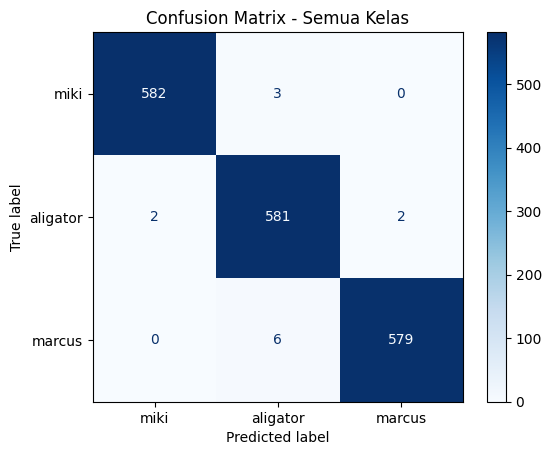

Classification Report - Semua Kelas:
              precision    recall  f1-score   support

        miki       1.00      0.99      1.00       585
    aligator       0.98      0.99      0.99       585
      marcus       1.00      0.99      0.99       585

    accuracy                           0.99      1755
   macro avg       0.99      0.99      0.99      1755
weighted avg       0.99      0.99      0.99      1755

              precision    recall  f1-score      support
miki           0.996575  0.994872  0.995723   585.000000
aligator       0.984746  0.993162  0.988936   585.000000
marcus         0.996558  0.989744  0.993139   585.000000
accuracy       0.992593  0.992593  0.992593     0.992593
macro avg      0.992626  0.992593  0.992599  1755.000000
weighted avg   0.992626  0.992593  0.992599  1755.000000


In [ ]:
# Inisialisasi
y_true_all = []
y_pred_all = []

# Loop untuk mengumpulkan prediksi dan label dari seluruh test data
for image_batch, label_batch in classification_test_ds_16:
    predictions = clf_model_class1.predict(image_batch)
    predicted_labels = tf.argmax(predictions, axis=1).numpy()

    y_true_all.extend(label_batch.numpy())
    y_pred_all.extend(predicted_labels)

# Confusion Matrix
cm = confusion_matrix(y_true_all, y_pred_all)
display_labels = [label_map[i] for i in sorted(set(y_true_all + y_pred_all))]  # label_map = {0: "Kelas 1", 1: "Kelas 2", 2: "Kelas 3"}
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

# Visualisasi
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Semua Kelas")
plt.grid(False)
plt.show()

# Classification Report
print("Classification Report - Semua Kelas:")
print(classification_report(y_true_all, y_pred_all, target_names=display_labels))

# (Opsional) Tampilkan sebagai DataFrame
report_df = pd.DataFrame(
    classification_report(
        y_true_all,
        y_pred_all,
        target_names=display_labels,
        output_dict=True
)
).transpose()
print(report_df)

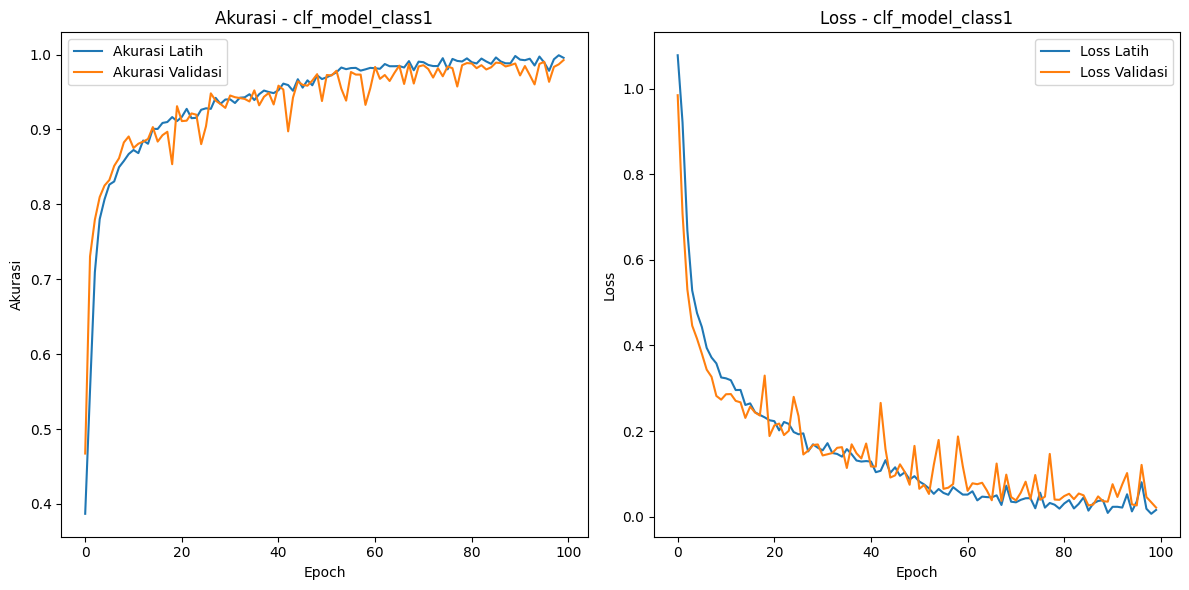

In [ ]:
import matplotlib.pyplot as plt

# Plot History untuk clf_model_class1
plt.figure(figsize=(12, 6))

# Plot Akurasi dan Loss untuk clf_model_class1
plt.subplot(1, 2, 1)  # Subplot pertama untuk akurasi
plt.plot(history_class1.history['accuracy'], label='Akurasi Latih')
plt.plot(history_class1.history['val_accuracy'], label='Akurasi Validasi')
plt.title("Akurasi - clf_model_class1")
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend(loc='best')

plt.subplot(1, 2, 2)  # Subplot kedua untuk loss
plt.plot(history_class1.history['loss'], label='Loss Latih')
plt.plot(history_class1.history['val_loss'], label='Loss Validasi')
plt.title("Loss - clf_model_class1")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

##***TRAINING CLASS BS 32***##

In [ ]:
history_class2 = clf_model_class2.fit(
    classification_train_ds_32,   # dataset sudah dibatch dengan batch size 32
    validation_data=classification_test_ds_32,   # dataset validation juga sudah dibatch
    epochs=100,
    callbacks=callbacks_class2
)

Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.3550 - loss: 1.0971

128/128 ━━━━━━━━━━━━━━━━━━━━ 25s 143ms/step - accuracy: 0.3551 - loss: 1.0970 - val_accuracy: 0.5499 - val_loss: 1.0592
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5121 - loss: 0.9866

128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 168ms/step - accuracy: 0.5126 - loss: 0.9860 - val_accuracy: 0.7453 - val_loss: 0.6683
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7155 - loss: 0.6855

128/128 ━━━━━━━━━━━━━━━━━━━━ 35s 122ms/step - accuracy: 0.7155 - loss: 0.6854 - val_accuracy: 0.7145 - val_loss: 0.6247
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7456 - loss: 0.6191

128/128 ━━━━━━━━━━━━━━━━━━━━ 25s 157ms/step - accuracy: 0.7456 - loss: 0.6188 - val_accuracy: 0.7527 - val_loss: 0.5481
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - accuracy: 0.7721 - loss: 0.5583 - val_accuracy: 0.6963 - val_loss: 0.6628
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7863 - loss: 0.5207

128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.7863 - loss: 0.5206 - val_accuracy: 0.8296 - val_loss: 0.4453
Epoch 7/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8084 - loss: 0.4756

128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - accuracy: 0.8083 - loss: 0.4757 - val_accuracy: 0.8291 - val_loss: 0.4322
Epoch 8/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - accuracy: 0.8147 - loss: 0.4454 - val_accuracy: 0.8006 - val_loss: 0.4843
Epoch 9/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8176 - loss: 0.4403

128/128 ━━━━━━━━━━━━━━━━━━━━ 26s 164ms/step - accuracy: 0.8176 - loss: 0.4403 - val_accuracy: 0.8433 - val_loss: 0.4023
Epoch 10/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8319 - loss: 0.4038

128/128 ━━━━━━━━━━━━━━━━━━━━ 16s 123ms/step - accuracy: 0.8320 - loss: 0.4038 - val_accuracy: 0.8496 - val_loss: 0.3919
Epoch 11/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - accuracy: 0.8272 - loss: 0.4013 - val_accuracy: 0.8279 - val_loss: 0.4285
Epoch 12/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - accuracy: 0.8467 - loss: 0.3932 - val_accuracy: 0.8450 - val_loss: 0.3964
Epoch 13/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8539 - loss: 0.3613

128/128 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 0.8540 - loss: 0.3612 - val_accuracy: 0.8946 - val_loss: 0.2928
Epoch 14/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - accuracy: 0.8610 - loss: 0.3394 - val_accuracy: 0.8860 - val_loss: 0.3129
Epoch 15/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - accuracy: 0.8663 - loss: 0.3301 - val_accuracy: 0.8809 - val_loss: 0.3151
Epoch 16/100
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8675 - loss: 0.3339

128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 128ms/step - accuracy: 0.8676 - loss: 0.3339 - val_accuracy: 0.9157 - val_loss: 0.2338
Epoch 17/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8756 - loss: 0.3098

128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - accuracy: 0.8756 - loss: 0.3098 - val_accuracy: 0.9162 - val_loss: 0.2279
Epoch 18/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - accuracy: 0.8771 - loss: 0.2999 - val_accuracy: 0.9037 - val_loss: 0.2622
Epoch 19/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8739 - loss: 0.3094

128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - accuracy: 0.8739 - loss: 0.3094 - val_accuracy: 0.9179 - val_loss: 0.2236
Epoch 20/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 118ms/step - accuracy: 0.8980 - loss: 0.2679 - val_accuracy: 0.9111 - val_loss: 0.2347
Epoch 21/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8967 - loss: 0.2671

128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - accuracy: 0.8967 - loss: 0.2671 - val_accuracy: 0.9151 - val_loss: 0.2178
Epoch 22/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9059 - loss: 0.2532

128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.9059 - loss: 0.2531 - val_accuracy: 0.9311 - val_loss: 0.1940
Epoch 23/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9117 - loss: 0.2360

128/128 ━━━━━━━━━━━━━━━━━━━━ 16s 122ms/step - accuracy: 0.9117 - loss: 0.2360 - val_accuracy: 0.9339 - val_loss: 0.1848
Epoch 24/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - accuracy: 0.9040 - loss: 0.2674 - val_accuracy: 0.9259 - val_loss: 0.1884
Epoch 25/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 117ms/step - accuracy: 0.9108 - loss: 0.2224 - val_accuracy: 0.9219 - val_loss: 0.2113
Epoch 26/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9046 - loss: 0.2383

128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 117ms/step - accuracy: 0.9047 - loss: 0.2383 - val_accuracy: 0.9368 - val_loss: 0.1768
Epoch 27/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9332 - loss: 0.1869

128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.9332 - loss: 0.1869 - val_accuracy: 0.9385 - val_loss: 0.1581
Epoch 28/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 16s 121ms/step - accuracy: 0.9202 - loss: 0.2072 - val_accuracy: 0.9407 - val_loss: 0.1587
Epoch 29/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - accuracy: 0.9304 - loss: 0.1894 - val_accuracy: 0.9362 - val_loss: 0.1643
Epoch 30/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - accuracy: 0.9336 - loss: 0.1891 - val_accuracy: 0.9311 - val_loss: 0.1818
Epoch 31/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 16s 123ms/step - accuracy: 0.9190 - loss: 0.2111 - val_accuracy: 0.9390 - val_loss: 0.1625
Epoch 32/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 19s 115ms/step - accuracy: 0.9388 - loss: 0.1700 - val_accuracy: 0.9311 - val_loss: 0.1728
Epoch 33/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9421 - loss: 0.1636

128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - accuracy: 0.9421 - loss: 0.1636 - val_accuracy: 0.9442 - val_loss: 0.1527
Epoch 34/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9395 - loss: 0.1595

128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 117ms/step - accuracy: 0.9395 - loss: 0.1596 - val_accuracy: 0.9476 - val_loss: 0.1374
Epoch 35/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9396 - loss: 0.1620

128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 116ms/step - accuracy: 0.9395 - loss: 0.1621 - val_accuracy: 0.9493 - val_loss: 0.1307
Epoch 36/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 121ms/step - accuracy: 0.9431 - loss: 0.1560 - val_accuracy: 0.9476 - val_loss: 0.1317
Epoch 37/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - accuracy: 0.9365 - loss: 0.1786 - val_accuracy: 0.9299 - val_loss: 0.1699
Epoch 38/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9419 - loss: 0.1579

128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 126ms/step - accuracy: 0.9419 - loss: 0.1579 - val_accuracy: 0.9556 - val_loss: 0.1244
Epoch 39/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - accuracy: 0.9457 - loss: 0.1464 - val_accuracy: 0.9481 - val_loss: 0.1372
Epoch 40/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - accuracy: 0.9496 - loss: 0.1441 - val_accuracy: 0.9527 - val_loss: 0.1309
Epoch 41/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - accuracy: 0.9550 - loss: 0.1339 - val_accuracy: 0.9493 - val_loss: 0.1445
Epoch 42/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 16s 121ms/step - accuracy: 0.9505 - loss: 0.1351 - val_accuracy: 0.9499 - val_loss: 0.1298
Epoch 43/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - accuracy: 0.9549 - loss: 0.1276 - val_accuracy: 0.9407 - val_loss: 0.1410
Epoch 44/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 109ms/step - accuracy: 0.9510 - loss: 0.1335 - val_accuracy: 0.9430 - val_loss: 0.1388
Epoch 45/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step - accuracy: 0.9508 - loss

128/128 ━━━━━━━━━━━━━━━━━━━━ 16s 121ms/step - accuracy: 0.9633 - loss: 0.1148 - val_accuracy: 0.9573 - val_loss: 0.1038
Epoch 47/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9592 - loss: 0.1097

128/128 ━━━━━━━━━━━━━━━━━━━━ 16s 124ms/step - accuracy: 0.9591 - loss: 0.1097 - val_accuracy: 0.9590 - val_loss: 0.1032
Epoch 48/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 16s 121ms/step - accuracy: 0.9489 - loss: 0.1326 - val_accuracy: 0.9516 - val_loss: 0.1127
Epoch 49/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - accuracy: 0.9575 - loss: 0.1106 - val_accuracy: 0.9407 - val_loss: 0.1411
Epoch 50/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9541 - loss: 0.1284

128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - accuracy: 0.9541 - loss: 0.1283 - val_accuracy: 0.9641 - val_loss: 0.0954
Epoch 51/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - accuracy: 0.9660 - loss: 0.1006 - val_accuracy: 0.9550 - val_loss: 0.1234
Epoch 52/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9668 - loss: 0.0964

128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 122ms/step - accuracy: 0.9668 - loss: 0.0965 - val_accuracy: 0.9613 - val_loss: 0.0938
Epoch 53/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.9644 - loss: 0.0980 - val_accuracy: 0.9584 - val_loss: 0.1047
Epoch 54/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 114ms/step - accuracy: 0.9695 - loss: 0.0814 - val_accuracy: 0.9533 - val_loss: 0.1254
Epoch 55/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9696 - loss: 0.0847

128/128 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 0.9696 - loss: 0.0848 - val_accuracy: 0.9607 - val_loss: 0.0912
Epoch 56/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - accuracy: 0.9604 - loss: 0.1014 - val_accuracy: 0.9487 - val_loss: 0.1215
Epoch 57/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - accuracy: 0.9674 - loss: 0.0877 - val_accuracy: 0.9538 - val_loss: 0.1068
Epoch 58/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - accuracy: 0.9733 - loss: 0.0769 - val_accuracy: 0.9544 - val_loss: 0.1115
Epoch 59/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9785 - loss: 0.0703

128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 116ms/step - accuracy: 0.9784 - loss: 0.0704 - val_accuracy: 0.9687 - val_loss: 0.0792
Epoch 60/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - accuracy: 0.9723 - loss: 0.0807 - val_accuracy: 0.9510 - val_loss: 0.1278
Epoch 61/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - accuracy: 0.9633 - loss: 0.0928 - val_accuracy: 0.9550 - val_loss: 0.1184
Epoch 62/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 121ms/step - accuracy: 0.9823 - loss: 0.0595 - val_accuracy: 0.9658 - val_loss: 0.0892
Epoch 63/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - accuracy: 0.9764 - loss: 0.0653 - val_accuracy: 0.9561 - val_loss: 0.0955
Epoch 64/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - accuracy: 0.9758 - loss: 0.0725 - val_accuracy: 0.9618 - val_loss: 0.1042
Epoch 65/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - accuracy: 0.9829 - loss: 0.0477 - val_accuracy: 0.9635 - val_loss: 0.0992
Epoch 66/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - accuracy: 0.9766 - loss

128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 117ms/step - accuracy: 0.9766 - loss: 0.0679 - val_accuracy: 0.9744 - val_loss: 0.0637
Epoch 68/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.9768 - loss: 0.0684 - val_accuracy: 0.9573 - val_loss: 0.1125
Epoch 69/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 114ms/step - accuracy: 0.9781 - loss: 0.0637 - val_accuracy: 0.9618 - val_loss: 0.1017
Epoch 70/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - accuracy: 0.9837 - loss: 0.0467 - val_accuracy: 0.9504 - val_loss: 0.1348
Epoch 71/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 16s 122ms/step - accuracy: 0.9862 - loss: 0.0428 - val_accuracy: 0.9664 - val_loss: 0.0936
Epoch 72/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step - accuracy: 0.9779 - loss: 0.0641 - val_accuracy: 0.9459 - val_loss: 0.1508
Epoch 73/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 16s 124ms/step - accuracy: 0.9819 - loss: 0.0458 - val_accuracy: 0.9601 - val_loss: 0.1079
Epoch 74/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.9701 - loss

128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 115ms/step - accuracy: 0.9743 - loss: 0.0754 - val_accuracy: 0.9789 - val_loss: 0.0574
Epoch 90/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.9891 - loss: 0.0327 - val_accuracy: 0.9453 - val_loss: 0.1669
Epoch 91/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 16s 121ms/step - accuracy: 0.9816 - loss: 0.0524 - val_accuracy: 0.9732 - val_loss: 0.0650
Epoch 92/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - accuracy: 0.9888 - loss: 0.0300 - val_accuracy: 0.9726 - val_loss: 0.0814
Epoch 93/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - accuracy: 0.9929 - loss: 0.0242 - val_accuracy: 0.9350 - val_loss: 0.2088
Epoch 94/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9905 - loss: 0.0318

128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 116ms/step - accuracy: 0.9905 - loss: 0.0318 - val_accuracy: 0.9835 - val_loss: 0.0412
Epoch 95/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - accuracy: 0.9921 - loss: 0.0273 - val_accuracy: 0.9772 - val_loss: 0.0717
Epoch 96/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 121ms/step - accuracy: 0.9891 - loss: 0.0390 - val_accuracy: 0.9738 - val_loss: 0.0670
Epoch 97/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.9933 - loss: 0.0230 - val_accuracy: 0.9863 - val_loss: 0.0537
Epoch 98/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9864 - loss: 0.0368

128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - accuracy: 0.9864 - loss: 0.0367 - val_accuracy: 0.9835 - val_loss: 0.0368
Epoch 99/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - accuracy: 0.9961 - loss: 0.0171 - val_accuracy: 0.9755 - val_loss: 0.0778
Epoch 100/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 116ms/step - accuracy: 0.9934 - loss: 0.0237 - val_accuracy: 0.9516 - val_loss: 0.1393


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 

<Figure size 800x600 with 0 Axes>

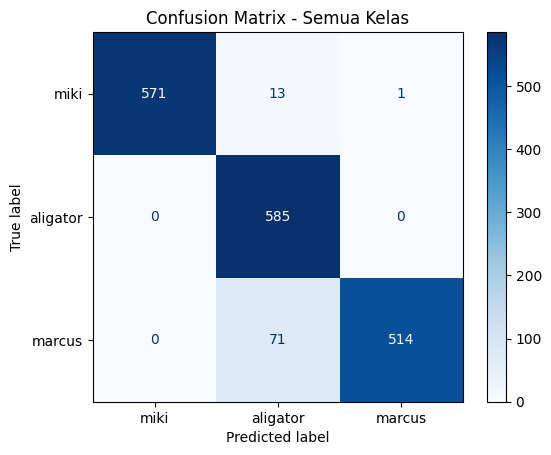

Classification Report - Semua Kelas:
              precision    recall  f1-score   support

        miki       1.00      0.98      0.99       585
    aligator       0.87      1.00      0.93       585
      marcus       1.00      0.88      0.93       585

    accuracy                           0.95      1755
   macro avg       0.96      0.95      0.95      1755
weighted avg       0.96      0.95      0.95      1755

              precision    recall  f1-score      support
miki           1.000000  0.976068  0.987889   585.000000
aligator       0.874439  1.000000  0.933014   585.000000
marcus         0.998058  0.878632  0.934545   585.000000
accuracy       0.951567  0.951567  0.951567     0.951567
macro avg      0.957499  0.951567  0.951816  1755.000000
weighted avg   0.957499  0.951567  0.951816  1755.000000


In [ ]:
# Inisialisasi
y_true_all2 = []
y_pred_all2 = []

# Loop untuk mengumpulkan prediksi dan label dari seluruh test data
for image_batch, label_batch in classification_test_ds_32:
    predictions = clf_model_class2.predict(image_batch)
    predicted_labels = tf.argmax(predictions, axis=1).numpy()

    y_true_all2.extend(label_batch.numpy())
    y_pred_all2.extend(predicted_labels)

# Confusion Matrix
cm = confusion_matrix(y_true_all2, y_pred_all2)
display_labels = [label_map[i] for i in sorted(set(y_true_all2 + y_pred_all2))]  # label_map = {0: "Kelas 1", 1: "Kelas 2", 2: "Kelas 3"}
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

# Visualisasi
plt.figure(figsize=(8, 6))
disp2.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Semua Kelas")
plt.grid(False)
plt.show()

# Classification Report
print("Classification Report - Semua Kelas:")
print(classification_report(y_true_all2, y_pred_all2, target_names=display_labels))

# (Opsional) Tampilkan sebagai DataFrame
report_df2 = pd.DataFrame(
    classification_report(
        y_true_all2,
        y_pred_all2,
        target_names=display_labels,
        output_dict=True
)
).transpose()
print(report_df2)

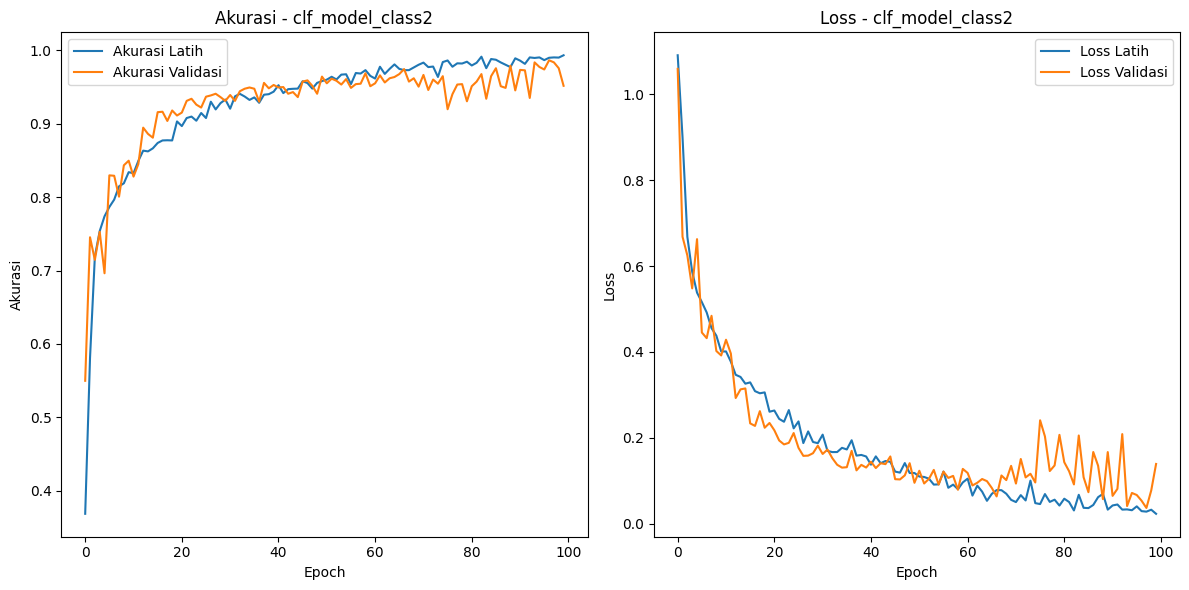

In [ ]:
# Plot History untuk clf_model_class2
plt.figure(figsize=(12, 6))

# Plot Akurasi dan Loss untuk clf_model_class2
plt.subplot(1, 2, 1)  # Subplot pertama untuk akurasi
plt.plot(history_class2.history['accuracy'], label='Akurasi Latih')
plt.plot(history_class2.history['val_accuracy'], label='Akurasi Validasi')
plt.title("Akurasi - clf_model_class2")
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend(loc='best')

plt.subplot(1, 2, 2)  # Subplot kedua untuk loss
plt.plot(history_class2.history['loss'], label='Loss Latih')
plt.plot(history_class2.history['val_loss'], label='Loss Validasi')
plt.title("Loss - clf_model_class2")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


##**VISUALISASI AKHIR**##

In [ ]:
def visualize_all_test_images(image_paths, mask_paths, labels, masked_image_paths, clf_model_class1, label_map, max_visualize=None):
    label_names = label_map
    num_samples = len(image_paths)

    if max_visualize is not None:
        num_samples = min(num_samples, max_visualize)

    for i in range(num_samples):
        image_path = image_paths[i]
        mask_path = mask_paths[i]
        masked_image_path = masked_image_paths[i]
        true_label_idx = labels[i]

        # Load original image
        image_raw = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image_raw, channels=3)
        image = tf.image.resize(image, [128, 128])
        image = tf.cast(image, tf.float32) / 255.0

        # Load ground truth mask (if available)
        try:
            mask_raw = tf.io.read_file(mask_path)
            gt_mask = tf.image.decode_jpeg(mask_raw, channels=1)
            gt_mask = tf.image.resize(gt_mask, [128, 128])
            gt_mask = tf.cast(gt_mask, tf.float32)
        except:
            gt_mask = tf.zeros((128, 128, 1), dtype=tf.float32)

        # Load masked image (hasil segmentasi offline)
        masked_image_raw = tf.io.read_file(masked_image_path)
        masked_image = tf.image.decode_jpeg(masked_image_raw, channels=3)
        masked_image = tf.image.resize(masked_image, [128, 128])
        masked_image = tf.cast(masked_image, tf.float32) / 255.0

        # Predict label with classifier
        pred_probs = clf_model_class1(tf.expand_dims(masked_image, 0), training=False)
        pred_label_idx = int(tf.argmax(pred_probs, axis=-1).numpy()[0])

        # Convert label index to string
        true_label_str = label_names.get(true_label_idx, f"Unknown ({true_label_idx})")
        pred_label_str = label_names.get(pred_label_idx, f"Unknown ({pred_label_idx})")

        # Visualisasi
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))

        axes[0].imshow(image.numpy())
        axes[0].set_title("Original Image")
        axes[0].axis('off')

        axes[1].imshow(gt_mask, cmap='gray')
        axes[1].set_title("Ground Truth Mask")
        axes[1].axis('off')

        axes[2].imshow(masked_image.numpy())
        axes[2].set_title("Masked Image (Hasil Segmentasi)")
        axes[2].axis('off')

        axes[3].imshow(masked_image.numpy())
        axes[3].set_title(f"Label Asli: {true_label_str}\nPrediksi: {pred_label_str}")
        axes[3].axis('off')

        filename = os.path.basename(image_path)
        plt.suptitle(f"Visualisasi: {filename}", fontsize=14, y=1.02)
        plt.tight_layout()
        plt.show()


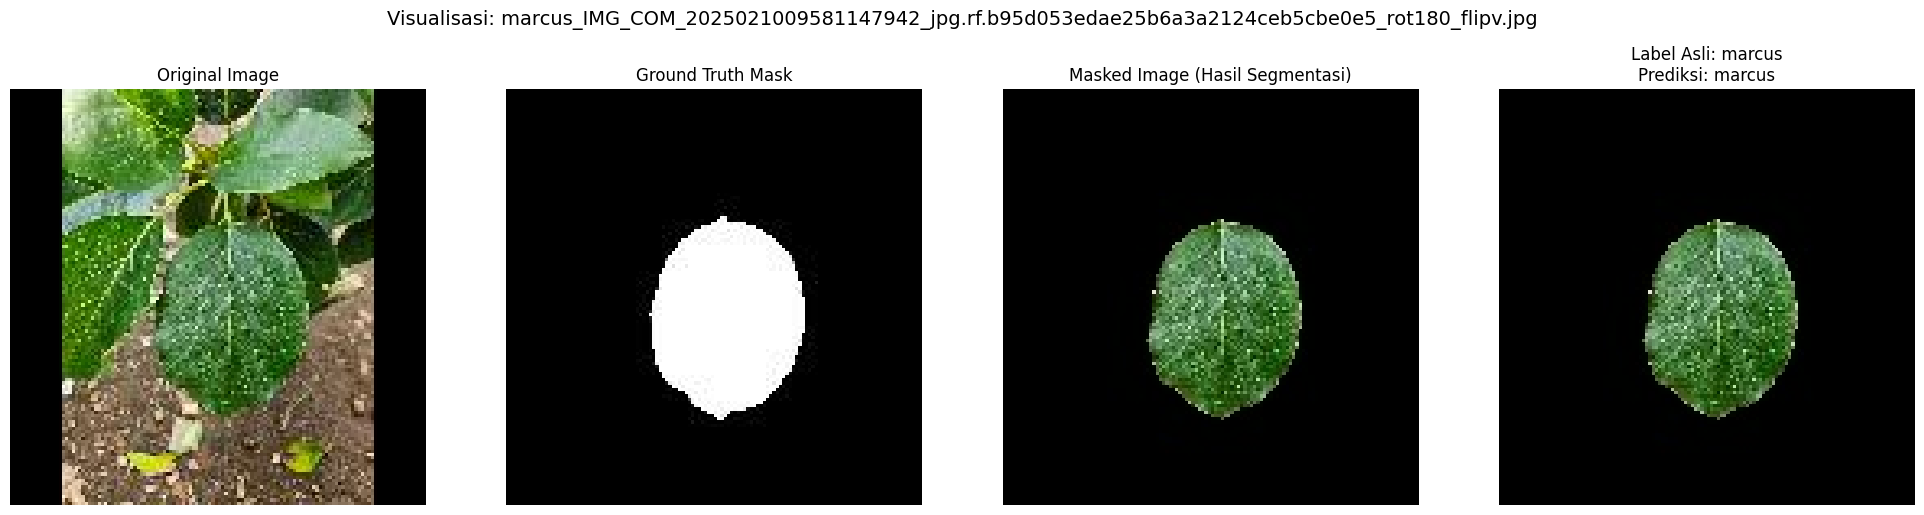

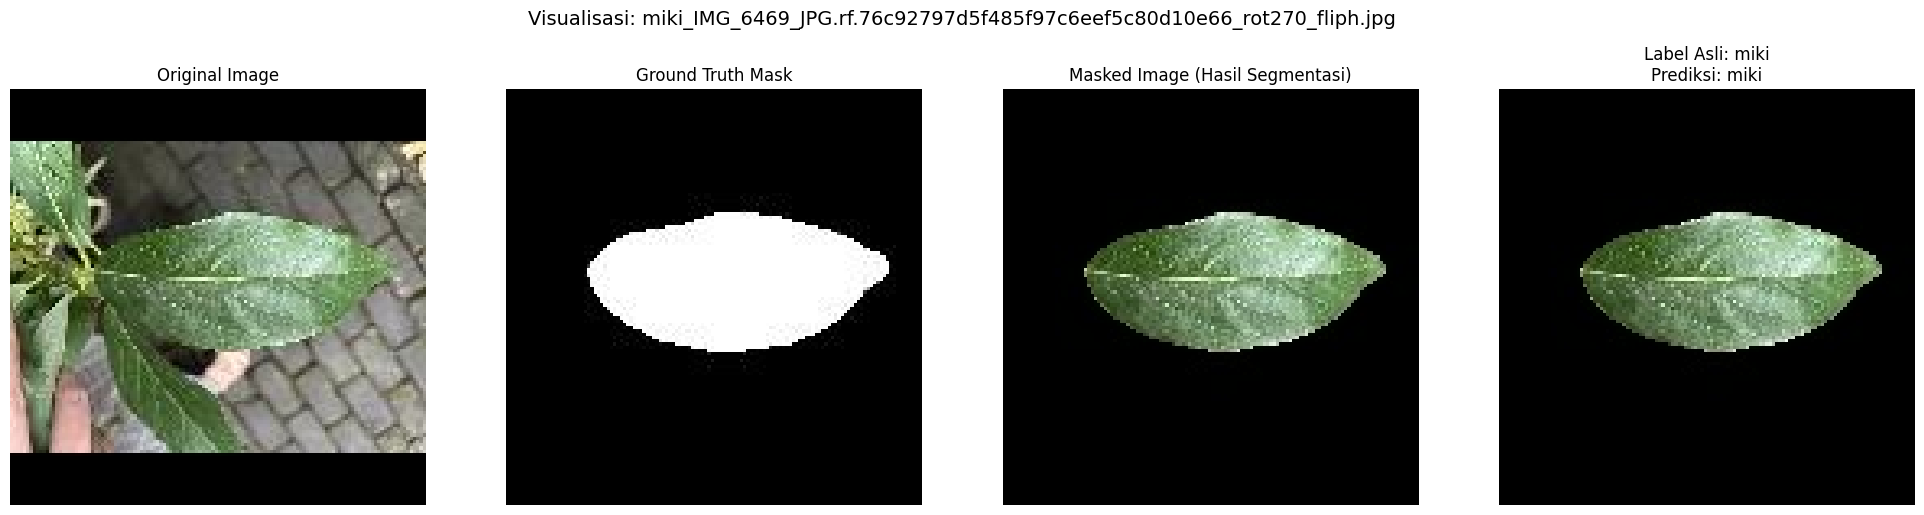

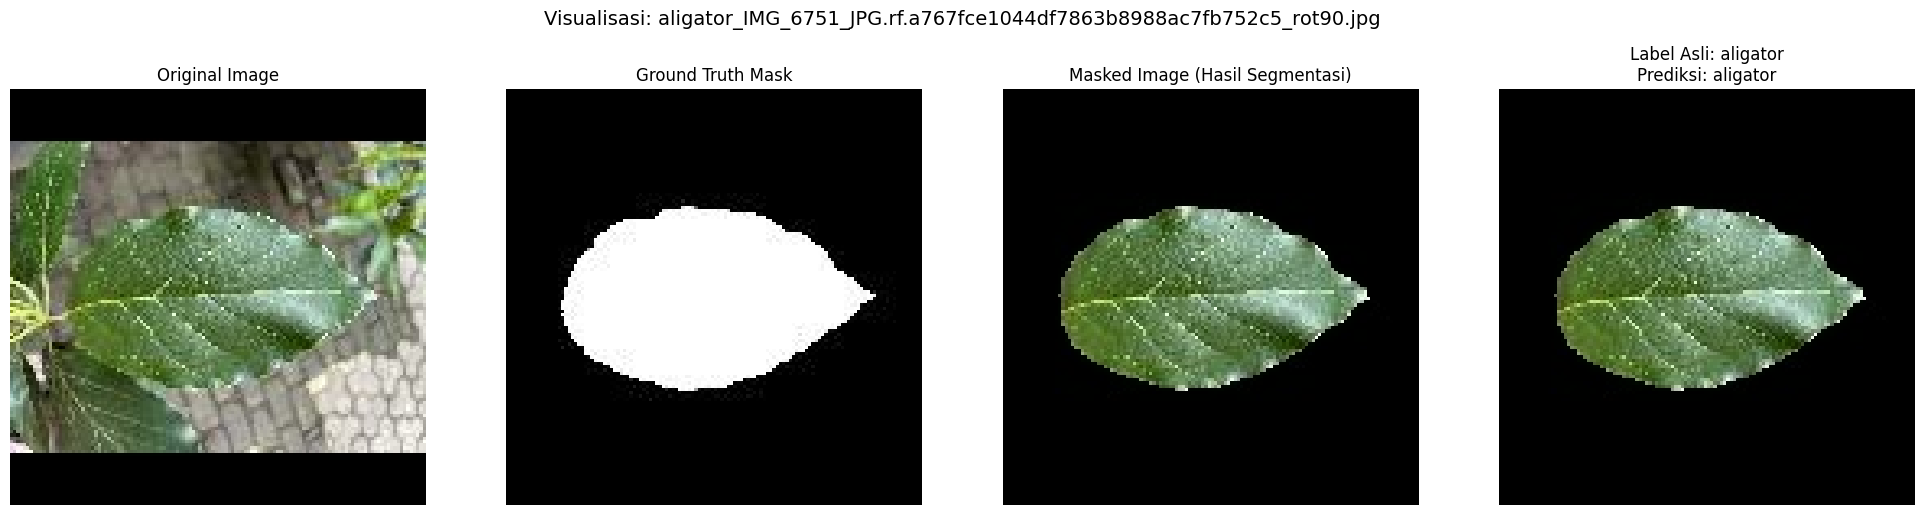

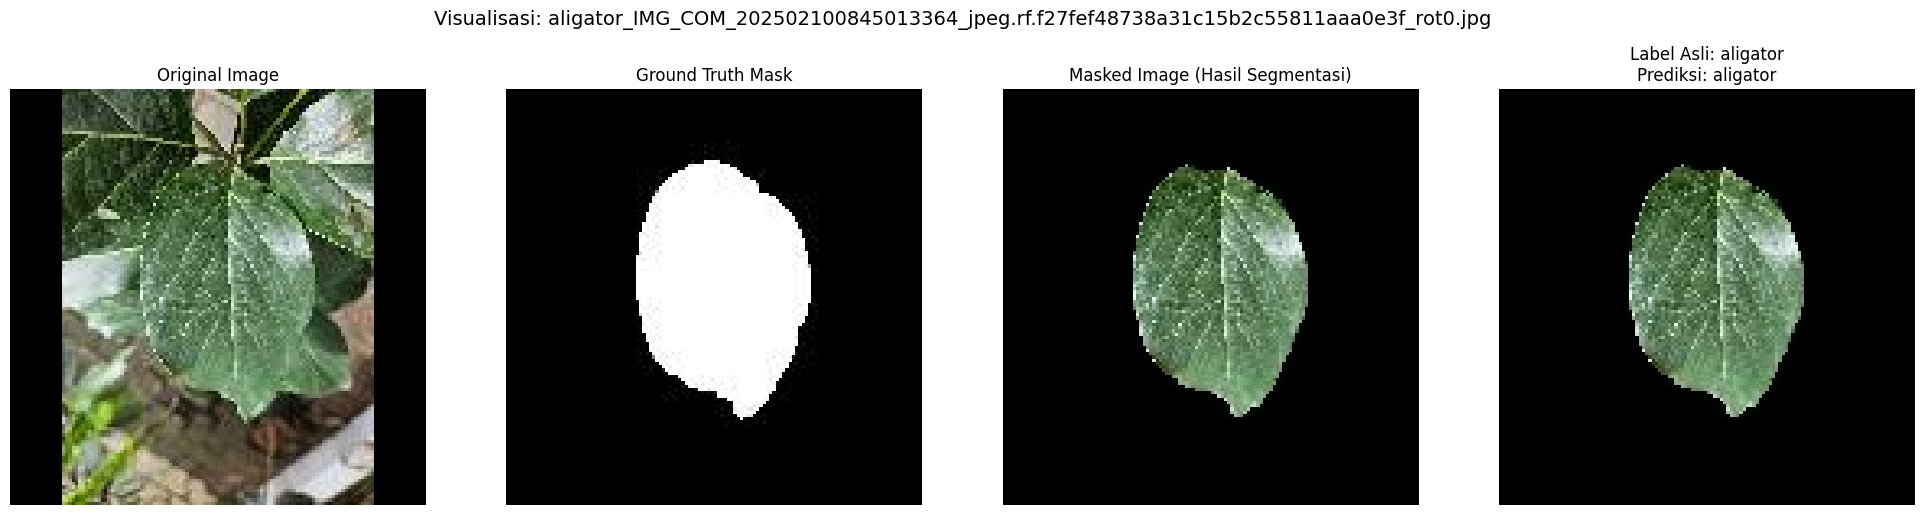

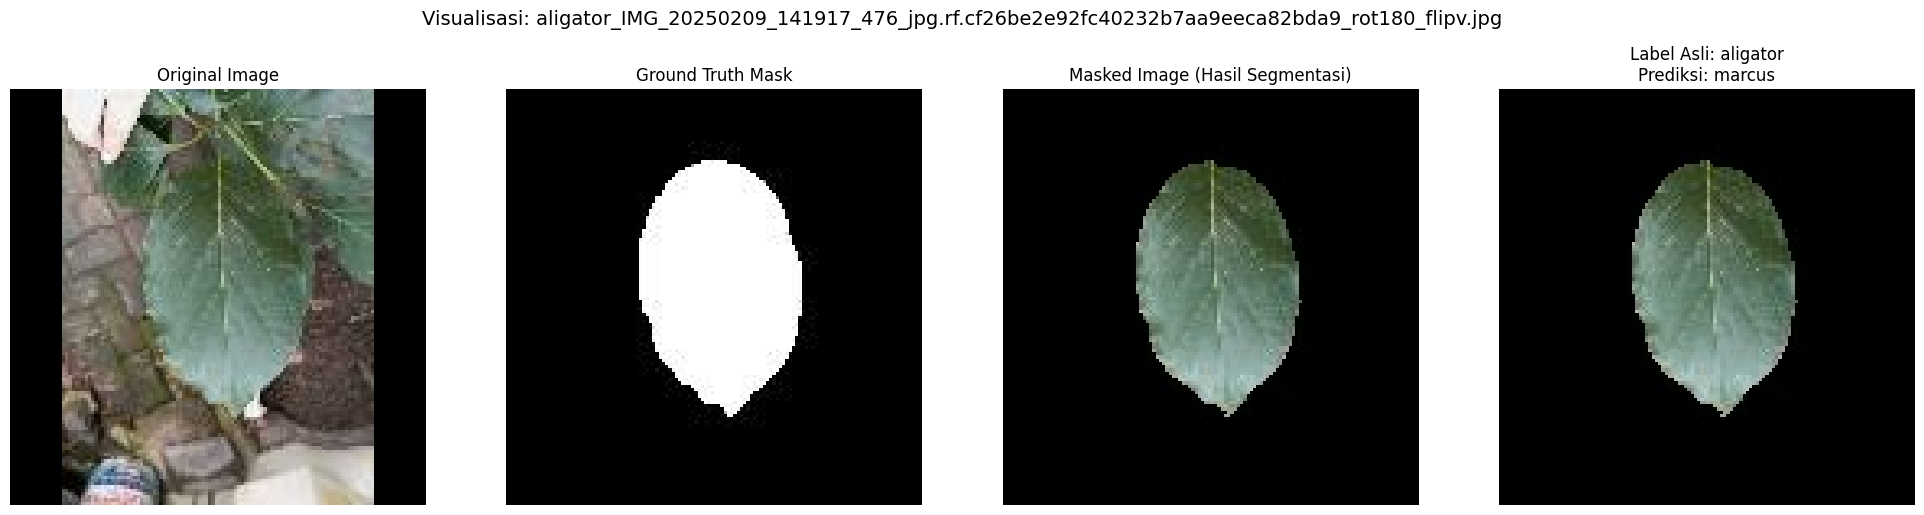

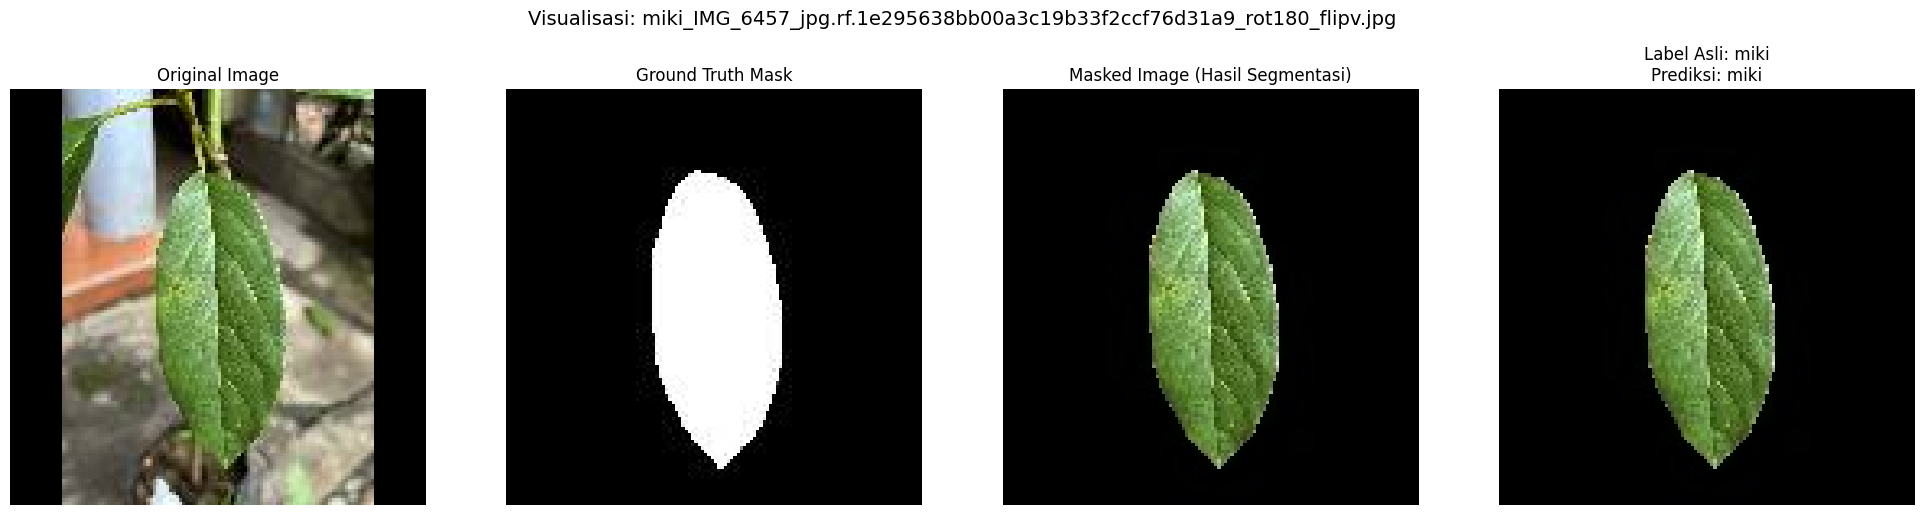

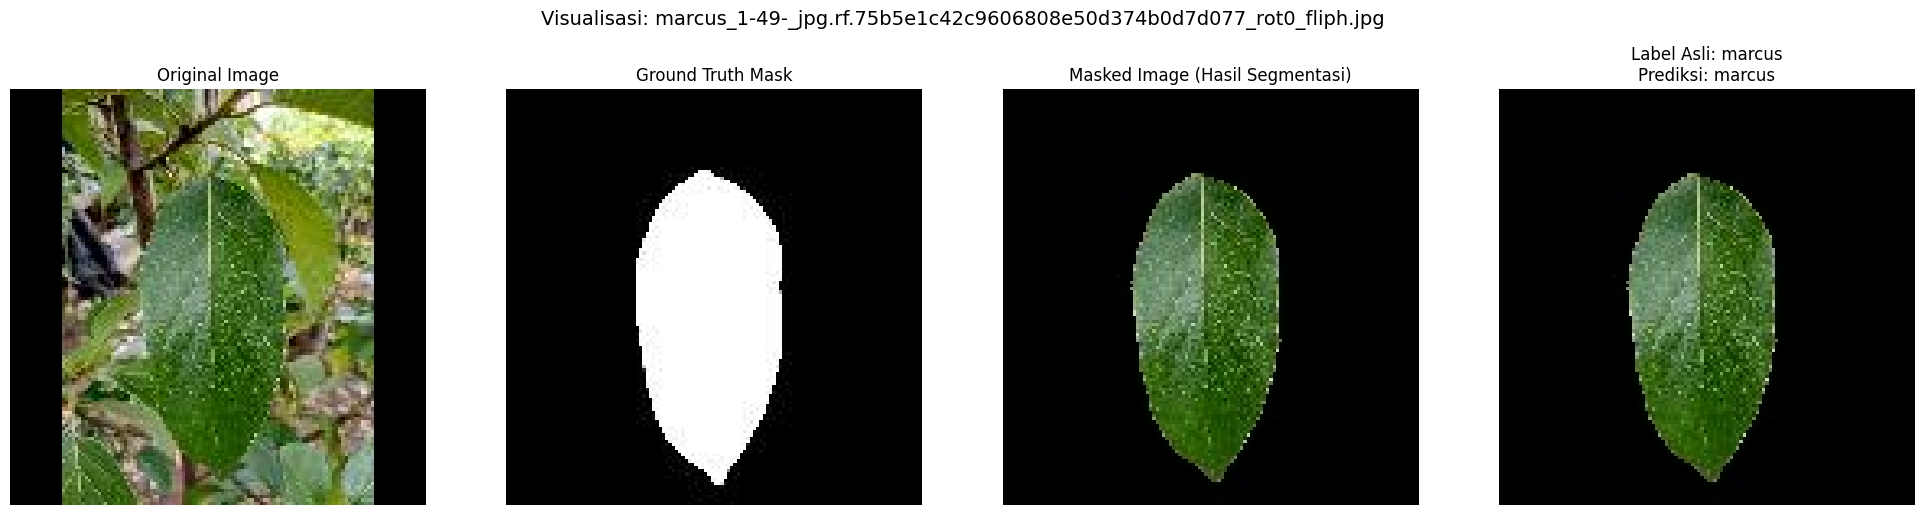

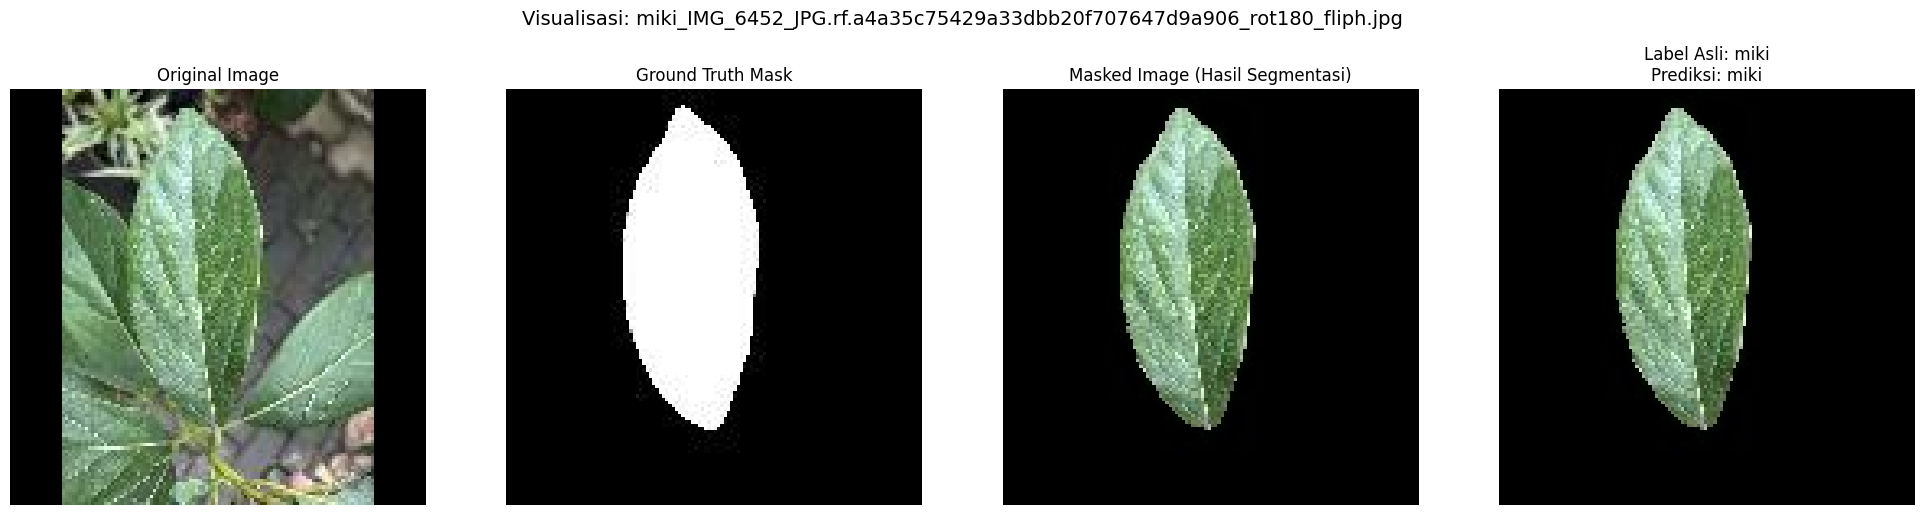

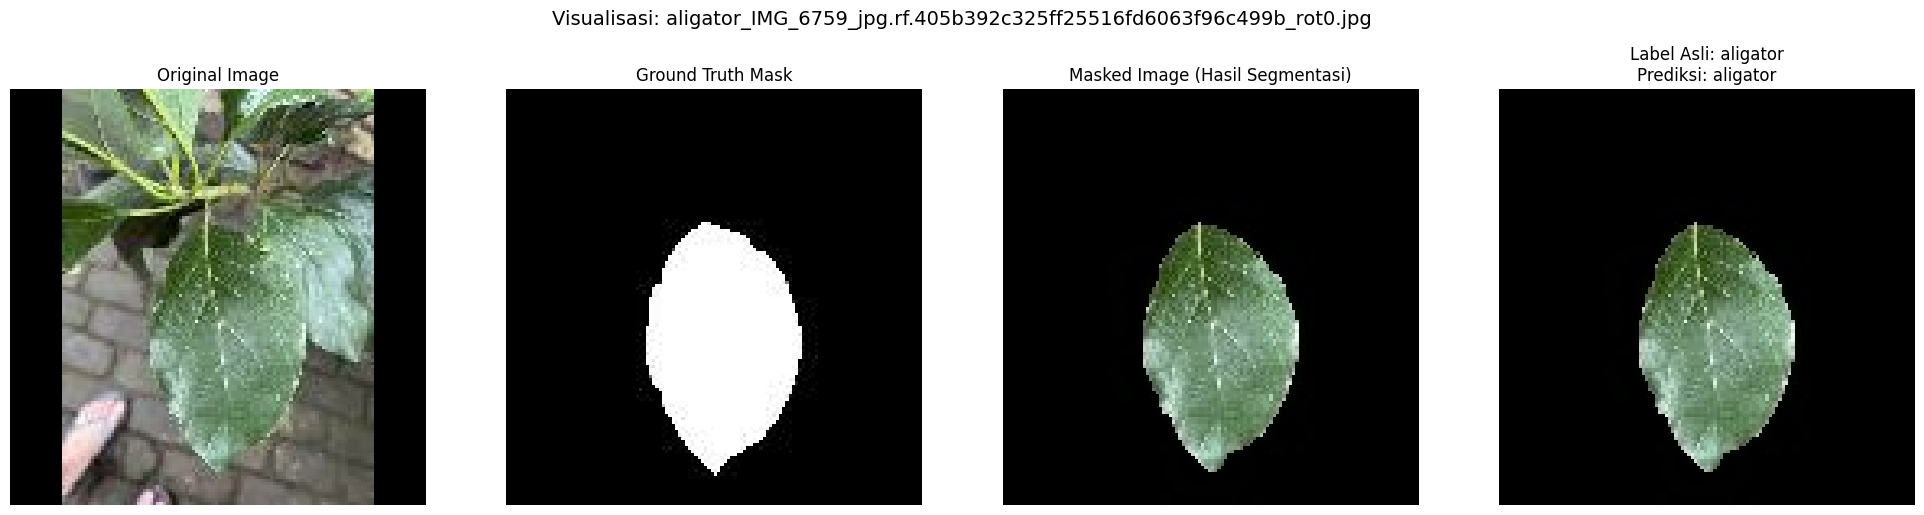

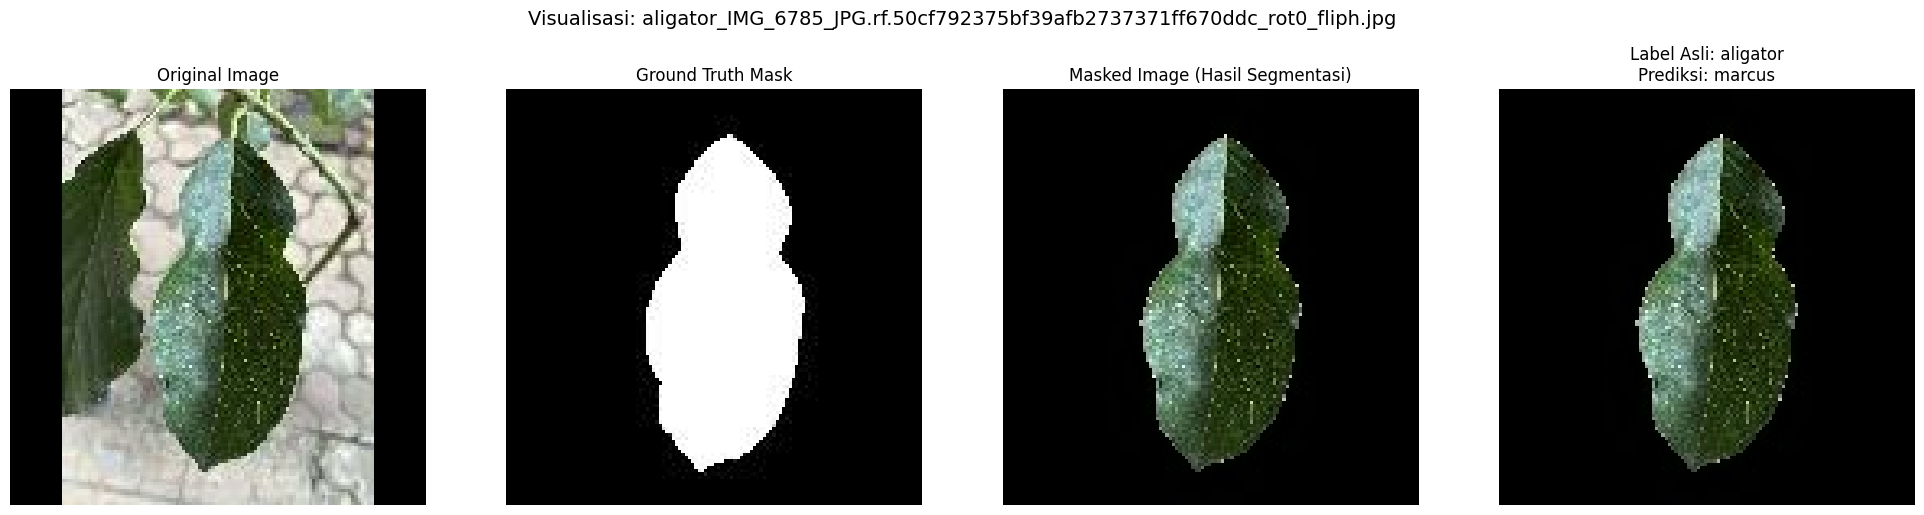

In [ ]:
visualize_all_test_images(
    image_paths=test_image_paths,
    mask_paths=test_mask_paths,
    labels=test_labels,
    masked_image_paths=[os.path.join("maskedrsunet02_test", os.path.basename(p)) for p in test_image_paths],  # list of saved masked image filepaths
    clf_model_class1=clf_model_class1,
    label_map=label_map,
    max_visualize=10
)